In [1]:
import ipywidgets as widgets
from IPython.display import display
import configparser
import subprocess
import numpy as np
import cmath as cm
from math import *
from matplotlib import pylab as plt

# THE CIMR OCEAN RETRIEVAL SYSTEM

## REQUIREMENTS
Linux System with 64 Go of RAM


## I - STEPS TO BUILD THE CIMR OCEAN RETRIEVAL SYSTEM

### 1) Download and Untar the Software on a local directory (tar = 1.7 GB, untar = 3.4 GB)

path = '~/cimr/'

cd path

wget https://cimr_bayesian_ocean_retrieval_system.tgz

tar xvf cimr_bayesian_ocean_retrieval_system.tgz

### 2) Download L1C file exemple (tar = 7.7 GB, untar = 13.8 GB)

wget https://cimr_sim_irma_amazon_rss_int_centroid_all_res_hbs_new3_ref_long.tgz

tar xvf cimr_sim_irma_amazon_rss_int_centroid_all_res_hbs_new3_ref_long.tgz

mv cimr_sim_irma_amazon_rss_int_centroid_all_res_hbs_new3_ref_long.mat cimr_bayesian_ocean_retrieval_system/pad/l1c/

### 3) Build supporting libraries


cd cimr_bayesian_ocean_retrieval_system/pad/lib/

./do.buildlibs

### 4) Build the CIMR ocean retrieval system executable

cd ../src/

make clean

INSTALL THE FOLLOWING LIBRARIES IF NOT INSTALLED YET:

sudo apt update

sudo apt-get install libxml2-dev libexpat1-dev zlib1g-dev libblas-dev libgeotiff-dev libtiff-dev libgsl-dev libquadmath0 libpng-dev libjpeg-dev uuid-dev libatlas-base-dev libopenblas-dev libopenblas-openmp-dev

make

## II - RUN the CIMR ocean retrieval system

cd bin/

### 1) Configure the config file : cimr_ocean_retrieval.cfg

In [2]:
def configure_config_file(config_file):
    
    # Read file and add a default section header if missing
    with open(config_file, "r") as f:
        lines = f.readlines()

    has_section_header = lines[0].startswith("[")
    
    if not has_section_header:
        lines.insert(0, "[DEFAULT]\n")  # Add temporary section header

    # Write the modified file (with section header) to a temp variable
    temp_config_file = "/tmp/temp_config.cfg"
    with open(temp_config_file, "w") as f:
        f.writelines(lines)

    # Load configparser with the modified file
    config = configparser.ConfigParser()
    config.read(temp_config_file)

    # Create checkbox widgets for parameters with 0/1 values
    def create_checkbox(param):
        return widgets.Checkbox(value=config.getboolean('DEFAULT', param), description=param)

    checkbox_params = [
        'calc_atm_lut', 'ret_res', 'do_ret_sss', 'do_ret_sstk',
        'do_ret_ws', 'do_ret_tcwv', 'do_ret_tclw', 'use_filt_harm_trigs', 'tb_type',
        ]
    
    checkbox_params1 = [
        'l_for_tbh','l_for_tbv','l_aft_tbh','l_aft_tbv',
        'c_for_tbh','c_for_tbv','c_aft_tbh','c_aft_tbv',
        'x_for_tbh','x_for_tbv','x_aft_tbh','x_aft_tbv',
        'ku_for_tbh','ku_for_tbv','ku_aft_tbh','ku_aft_tbv',
        'ka_for_tbh','ka_for_tbv','ka_aft_tbh','ka_aft_tbv',
        'l_for_tb3','l_for_tb4','l_aft_tb3','l_aft_tb4',
        'c_for_tb3','c_for_tb4','c_aft_tb3','c_aft_tb4',
        'x_for_tb3','x_for_tb4','x_aft_tb3','x_aft_tb4',
        'ku_for_tb3','ku_for_tb4','ku_aft_tb3','ku_aft_tb4',
        'ka_for_tb3','ka_for_tb4','ka_aft_tb3','ka_aft_tb4']

    checkboxes = {param: create_checkbox(param) for param in checkbox_params}
    checkboxes1 = {param: create_checkbox(param) for param in checkbox_params1}

    # Ensure the default value from the config file is included in options
    ifn_l1c_options = ['../l1c/cimr_sim_irma_amazon_rss_int_centroid_all_res_hbs_new3_ref_long.mat', 'option2', 'option3']  # Replace with actual options
    ifn_rough_lut_options = ['../luts/cimr_roughness_emissivity_lut.mat', 'option2', 'option3']  # Replace with actual options
    ifn_diel_lut_options = ['../luts/cimr_dielectric_lut_mw2012.mat', 'option2', 'option3']  # Replace with actual options
    ifn_atm_abs_lut_options = ['../luts/atm_abs_lut_rss.mat', 'option2', 'option3']  # Replace with actual options


    # If config['ifn_l1c'] is not in the list, add it
    default_ifn_l1c = '../l1c/cimr_sim_irma_amazon_rss_int_centroid_all_res_hbs_new3_ref_long.mat'
    default_ifn_rough_lut = '../luts/cimr_roughness_emissivity_lut.mat'
    default_ifn_diel_lut  = '../luts/cimr_dielectric_lut_mw2012.mat'
    default_ifn_atm_abs_lut = '../luts/atm_abs_lut_rss.mat'    

    # Create the Dropdown widget
    ifn_l1c = widgets.Dropdown(options=ifn_l1c_options,value=default_ifn_l1c,  # Ensure the value is in options
    description='L1C file:', layout={'width': 'max-content'})
    ifn_rough_lut = widgets.Dropdown(options=ifn_rough_lut_options,value=default_ifn_rough_lut,  # Ensure the value is in options
    description='Rouh LUT:', layout={'width': 'max-content'})
    ifn_diel_lut = widgets.Dropdown(options=ifn_diel_lut_options,value=default_ifn_diel_lut,  # Ensure the value is in options
    description='Diel LUT:', layout={'width': 'max-content'})
    ifn_atm_abs_lut = widgets.Dropdown(options=ifn_atm_abs_lut_options,value=default_ifn_atm_abs_lut,  # Ensure the value is in options
    description='Atmo LUT:', layout={'width': 'max-content'})
    
    ofn = widgets.Text(
    value=config['DEFAULT']['ofn'],
    description='Output file:',layout={'width': 'max-content'}
    )
    
    ofn_nc = ofn.value.replace('.mat','.nc')
    
    # Create widgets for Longitude and Latitude Min/Max
    lon_min = widgets.FloatText(value=float(config['DEFAULT'].get('lon_min', -60)), description='Lon Min:')
    lon_max = widgets.FloatText(value=float(config['DEFAULT'].get('lon_max', -50)), description='Lon Max:')
    lat_min = widgets.FloatText(value=float(config['DEFAULT'].get('lat_min', 17)), description='Lat Min:')
    lat_max = widgets.FloatText(value=float(config['DEFAULT'].get('lat_max', 30)), description='Lat Max:')
    
    # Create checkbox for "Use Prior Settings"
    use_prior_settings = widgets.Checkbox(value=False, description="Use Prior Settings")

    # Dictionary of prior and variance values
    prior_vars = {
        'prior_sstk': 290.0, 'prior_sss': 35.0, 'prior_ws': 7.0, 'prior_wd': 0.0,
        'prior_tcwv': 30.0, 'prior_tclw': -15.0, 'prior_tcrw': 0.0,
        'var_sstk': 100.0, 'var_sss': 0.2, 'var_ws': 3.0, 'var_wd': 10.0,
        'var_tcwv': 1.0, 'var_tclw': 5.0, 'var_tcrw': 1.0
    }

    # Create FloatText boxes for prior values
    prior_widgets = {key: widgets.FloatText(value=val, description=key) for key, val in prior_vars.items()}

    # Arrange prior widgets in a grid layout
    prior_grid = widgets.GridBox(
        children=list(prior_widgets.values()),
        layout=widgets.Layout(grid_template_columns="repeat(2, 350px)")
    )
    # Create an informative text before the prior input boxes
    prior_label = widgets.HTML("<b>Prior and Variance Values:</b><br>Modify the values or disable them using the checkbox below.")

    # Create a grid layout with checkboxes
    grid = widgets.GridBox(
        children=list(checkboxes.values()),
        layout=widgets.Layout(grid_template_columns="repeat(5, 150px)")
    )
    grid1 = widgets.GridBox(
        children=list(checkboxes1.values()),
        layout=widgets.Layout(grid_template_columns="repeat(5, 150px)")
    )
    grid1_label = widgets.HTML("<b>Specify which Tbs to use. 0 = do not use. 1 = use.</b>")

    display(ifn_l1c)
    display(ifn_rough_lut)
    display(ifn_diel_lut)
    display(ifn_atm_abs_lut)
    display(ofn)
    display(grid)
    display(widgets.HTML("<b>Set domain for retrieval:</b>"))
    display(widgets.HBox([lon_min, lon_max]))  # Longitude controls side by side
    display(widgets.HBox([lat_min, lat_max]))  # Latitude controls side by side
    display(prior_label) # Informative text
    display(use_prior_settings)  # Checkbox for prior settings
    display(prior_grid)  # Show editable prior values
    display(grid1_label)
    display(grid1)

    # Function to save widget values to the configuration file
    def save_config(b):
        # Restore the original format (no section header)
        with open(config_file, "w") as f:
            f.writelines("# I/O filenames set in the run script currently.\n")
            f.write(f"ifn_l1c = '{ifn_l1c.value}'\n")
            f.write(f"ifn_rough_lut = '{ifn_rough_lut.value}'\n")
            f.write(f"ifn_diel_lut = '{ifn_diel_lut.value}'\n")
            f.write(f"ifn_atm_abs_lut = '{ifn_atm_abs_lut.value}'\n")
            f.write(f"ofn = {ofn.value}\n")
            f.write(f"ofn_nc = {ofn_nc}\n")
            f.write("\n")
            for param, widget in checkboxes.items():
                f.write(f"{param} = {int(widget.value)}\n")  # Convert boolean to 0/1
            f.write("\n")
            f.write("# Uncomment to specify priors.\n")
            # Save prior/variance values based on checkbox state
            if use_prior_settings.value:
                for key, widget in prior_widgets.items():
                    f.write(f"{key} = {widget.value}\n")  # Save modified value
            else:
                for key, widget in prior_widgets.items():
                    f.write(f"# {key} = {widget.value}\n")  # Commented o
            f.write("\n")
            f.write("# Set limited domain for retrieval. Comment out for retrievals everywhere.\n")
            f.write(f"lon0 = {lon_min.value}\n")
            f.write(f"lon1 = {lon_max.value}\n")
            f.write(f"lat0 = {lat_min.value}\n")
            f.write(f"lat1 = {lat_max.value}\n")
            f.write("\n")
            f.write("Specify which Tbs to use. 0 = do not use. 1 = use.\n")
            for param, widget in checkboxes1.items():
                f.write(f"{param} = {int(widget.value)}\n")  # Convert boolean to 0/1

    # Create a button to save the configuration
    save_button = widgets.Button(description="Save Configuration",layout=widgets.Layout(border="2px solid black", width="200px", height="40px"),
        button_style="primary"  # You can also use "success", "info", "warning", "danger"
    )
    save_button.on_click(save_config)
    display(save_button)
configure_config_file('cimr_ocean_retrieval.cfg')

Dropdown(description='L1C file:', layout=Layout(width='max-content'), options=('../l1c/cimr_sim_irma_amazon_rs…

Dropdown(description='Rouh LUT:', layout=Layout(width='max-content'), options=('../luts/cimr_roughness_emissiv…

Dropdown(description='Diel LUT:', layout=Layout(width='max-content'), options=('../luts/cimr_dielectric_lut_mw…

Dropdown(description='Atmo LUT:', layout=Layout(width='max-content'), options=('../luts/atm_abs_lut_rss.mat', …

Text(value="'../l2c/cimr_retrieval_irma_amazon.mat'", description='Output file:', layout=Layout(width='max-con…

GridBox(children=(Checkbox(value=False, description='calc_atm_lut'), Checkbox(value=True, description='ret_res…

HTML(value='<b>Set domain for retrieval:</b>')

HTML(value='<b>Prior and Variance Values:</b><br>Modify the values or disable them using the checkbox below.')

Checkbox(value=False, description='Use Prior Settings')

GridBox(children=(FloatText(value=290.0, description='prior_sstk'), FloatText(value=35.0, description='prior_s…

HTML(value='<b>Specify which Tbs to use. 0 = do not use. 1 = use.</b>')

GridBox(children=(Checkbox(value=True, description='l_for_tbh'), Checkbox(value=True, description='l_for_tbv')…

Button(button_style='primary', description='Save Configuration', layout=Layout(border_bottom='2px solid black'…

### 2) Run the retrieval algorithm (call to the C executable "cimrOceanRetrievalSystem")

In [3]:
# Exécuter le programme C
#subprocess.run([cimrOceanRetrievalSystem, cimr_ocean_retrieval.cfg])

## III -  Make figures of the result

# Level-2 Ocean Wind Vector (OWV) prototype algorithm for CIMR

In what follows, we provide codes and results for each components of the Algorithm

## Sea Water Dielectric Constant models

We first provide the code for the dielectric constant model at L-band (1.1) and then (1.2) for the higher frequencies of CIMR. Illustrative plots of the real & imaginery parts as a function of Salinity (S) and Temperature (T) are provided at each frequency.



### Sea Water Dielectric Constant model at L-band

##############################################################

#### **epsilon = cdiel_cimr_L(S, T) [complex]**  

Computes the **complex dielectric constant** of sea water as a function of the following inputs:

#### **Inputs**  
- **Salinity S** **[pss]**  
- **Temperature T** **[K]**  

The computation is performed at an **electromagnetic frequency** of:  
- **f = 1.4 × 10⁹ Hz** (L-band)  

#### **Output**  
- **epsilon**: A **complex matrix** of size **[length(S), length(T)]**  
- Provides a value of **epsilon** for each **S** and **T**  
- Uses the model from **Zhou et al. (2021) for L-band**  

---

#### **References**  
1. **Y. Zhou, R. H. Lang, E.P. Dinnat, and D. M. Le Vine (2021)**  
   *Seawater Debye Model Function at L-band and its Impact on Salinity Retrieval from Aquarius Satellite Data.*  
   IEEE Transactions on Geoscience and Remote Sensing, **59(10)**:8103–8116.  

---

📌 **Code written by**: **Reul N. @ Ifremer**  
📅 **March 2023**  

##############################################################

In [4]:
def cdiel_cimr_L(S, T):

    T = T-273.15  # temperature in degree celsius [°C]

    # Input Parameters
    lS = np.size(S)               #length of vector S
    lT = np.size(T)               #length of vector T
    f  =1.4*1e9
    
    epsilono = 8.854e-12  #free-space permittivity.......[F/m]

    # Transformation of T and S into matrices [lSxlT]

    arr = np.array([S])
    repetitions = lT
    Sm = np.tile(arr,lT)
    arr = np.array([T])
    repetitions = lS
    Tm = np.tile(arr,lS)
    
    
    # Zhou et al. [2021]’s Debye model (GW2020) for the seawater dielectric constant is used  for the L-band channels (1.4 GHz) and is refered to as <<GW2020>> 
    # The model is based on the following equation:
    # static dielectric constant of distilled water
    eps_sdw =88.0516-4.01796e-1* Tm-5.1027e-5* Tm**2+2.55892e-5* Tm**3
    # relaxation time of distilled water:
    tau=1.75030e-11-6.12993e-13* Tm+1.24504e-14* Tm**2-1.14927e-16*Tm**3
    # factor in the static dielectric constant of seawater due to the presence of ions
    R_swdw=1-Sm*(3.97185e-3-2.49205e-5*Tm-4.27558e-5*Sm+3.92825e-7*Sm*Tm+4.15350e-7*Sm**2)
    # conductivity of distilled water
    sigma_fS0=9.50470e-2*Sm-4.30858e-4*Sm**2+2.16182e-6*Sm**3
    R_sigma=1+Tm*(3.76017e-2+6.32830e-5*Tm+4.83420e-7*Tm**2-3.97484e-4*Sm+6.26522e-6*Sm**2)
    # conductivity of sea water
    sigma=sigma_fS0*R_sigma
    # dielectric constant of distilled water at infinite frequency
    epsiloninf = 4.9
    # electromagnetic pulsation
    omega =2*pi*f #*1e-9   # f is in GHz
    # dielectric constant of sea water
    j = cm.sqrt(-1)
    epsilon =epsiloninf+((eps_sdw*R_swdw-epsiloninf)/(1+j*omega*tau))-((j*sigma)/(omega*epsilono))
    epsilon = np.conj(epsilon)

    return epsilon

#### Plot the dielectric constant over S and T ranges at the CIMR L-band frequency  

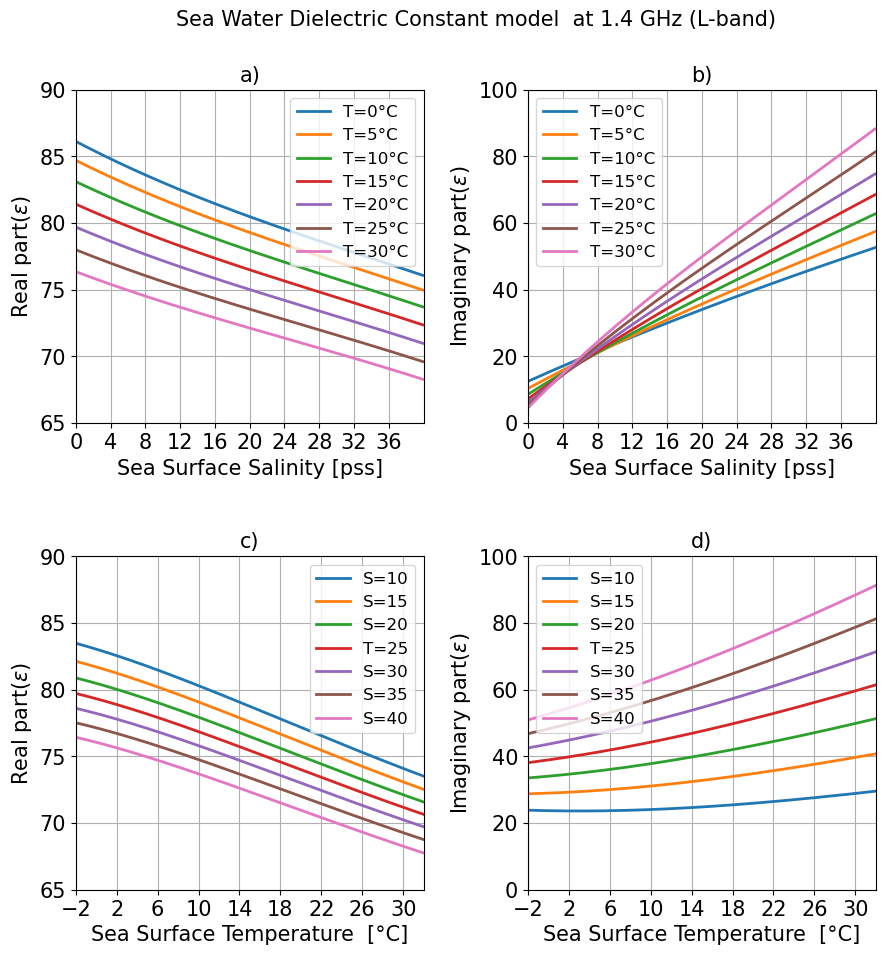

In [5]:
# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

f = 1.4*1e9

test = cdiel_cimr_L(So, To)
real_epsilon_L0 = test.real
imag_epsilon_L0 = test.imag

test = cdiel_cimr_L(So, T1)
real_epsilon_L1 = test.real
imag_epsilon_L1 = test.imag

test = cdiel_cimr_L(So, T2)
real_epsilon_L2 = test.real
imag_epsilon_L2 = test.imag

test = cdiel_cimr_L(So, T3)
real_epsilon_L3 = test.real
imag_epsilon_L3 = test.imag

test = cdiel_cimr_L(So, T4)
real_epsilon_L4 = test.real
imag_epsilon_L4 = test.imag

test = cdiel_cimr_L(So, T5)
real_epsilon_L5 = test.real
imag_epsilon_L5 = test.imag

test = cdiel_cimr_L(So, T6)
real_epsilon_L6 = test.real
imag_epsilon_L6 = test.imag


fig0, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig0.suptitle('Sea Water Dielectric Constant model  at 1.4 GHz (L-band)',fontsize=15)
fig0.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,np.transpose(real_epsilon_L0), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_L1), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_L2), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_L3), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_L4), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_L5), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_L6), '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 65, 90])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax1.set_title('a)',fontsize=15)
ax1.set_xticks(np.arange(0, 40, 4))
#ax1.set_yticks(np.arange(68.5, 90, 2.5))
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

ax2.plot(So,np.transpose(imag_epsilon_L0), '-', linewidth=2)
ax2.plot(So,np.transpose(imag_epsilon_L1), '-', linewidth=2)
ax2.plot(So,np.transpose(imag_epsilon_L2), '-', linewidth=2)
ax2.plot(So,np.transpose(imag_epsilon_L3), '-', linewidth=2)
ax2.plot(So,np.transpose(imag_epsilon_L4), '-', linewidth=2)
ax2.plot(So,np.transpose(imag_epsilon_L5), '-', linewidth=2)
ax2.plot(So,np.transpose(imag_epsilon_L6), '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 0, 100])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax2.set_title('b)',fontsize=15)
ax2.set_xticks(np.arange(0, 40, 4))
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 40, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40

test = cdiel_cimr_L(So, To)
real_epsilon_L7 = test.real
imag_epsilon_L7 = test.imag

test = cdiel_cimr_L(S1, To)
real_epsilon_L8 = test.real
imag_epsilon_L8 = test.imag

test = cdiel_cimr_L(S2, To)
real_epsilon_L9 = test.real
imag_epsilon_L9 = test.imag

test = cdiel_cimr_L(S3, To)
real_epsilon_L10 = test.real
imag_epsilon_L10 = test.imag

test = cdiel_cimr_L(S4, To)
real_epsilon_L11 = test.real
imag_epsilon_L11 = test.imag

test = cdiel_cimr_L(S5, To)
real_epsilon_L12 = test.real
imag_epsilon_L12 = test.imag

test = cdiel_cimr_L(S6, To)
real_epsilon_L13 = test.real
imag_epsilon_L13 = test.imag


ax3.plot(To-273.15,np.transpose(real_epsilon_L7), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_L8), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_L9), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_L10), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_L11), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_L12), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_L13), '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 65, 90])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax3.set_title('c)',fontsize=15)
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

ax4.plot(To-273.15,np.transpose(imag_epsilon_L7), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(imag_epsilon_L8), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(imag_epsilon_L9), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(imag_epsilon_L10), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(imag_epsilon_L11), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(imag_epsilon_L12), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(imag_epsilon_L13), '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 0, 100])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax4.set_title('d)',fontsize=15)
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid()
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
# set the spacing between subplots
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
plt.show()


### Sea Water Dielectric Constant model at C-,X-,Ku-,and Ka-bands

**epsilon = cdiel_cimr(S, T, freq) [complex]**  

Compute the complex dielectric constant of sea water  
as a function of the following inputs:  

- **Salinity S** [pss]  
- **Temperature T** [K]  
- **Electromagnetic frequency freq** [GHz]  

The output **epsilon**:  
- Is a **complex matrix** of size **[length(S), length(T)]**  
- Provides a value of epsilon for each value of **S** and **T**  
- Uses the **Meissner and Wentz [2004, 2012]** model  

---

### **References**  

1. **T. Meissner and F.J. Wentz (2004)**  
   *The complex dielectric constant of pure and sea water from microwave satellite observations.*  
   IEEE Transactions on Geoscience and Remote Sensing, **42(9)**:1836–1849.  

2. **T. Meissner and F.J. Wentz (2012)**  
   *The emissivity of the ocean surface between 6 and 90 GHz over a large range of wind speeds and earth incidence angles.*  
   IEEE Transactions on Geoscience and Remote Sensing, **50(8)**:3004–3026.  

---

**Code translated into Python by:**  
**Reul N.**, from T. Meissner (REMSS) Fortran code  
📧 *nicolas.reul@ifremer.fr*  
📅 *March 2023*  

In [6]:
def cdiel_cimr(SSS, SST, freq):

    SST = SST-273.15  # sea surface temperature in degree celsius [°C]

    
#    Input Parameters
    lS = np.size(SSS)               #length of vector SSS
    lT = np.size(SST)               #length of vector SST
        
    epsilono = 8.854e-12  #free-space permittivity.......[F/m]

#    Transformation of SST and SSS into matrices [lSxlT]

    arr = np.array([SSS])
    repetitions = lT
    Sm = np.tile(arr,lT)
    arr = np.array([SST])
    repetitions = lS
    Tm = np.tile(arr,lS)
    
 
    # ######################################################################
    #       Model of Wentz (2000) with update from                         #
    #       Meissner and Wentz [2004] & Meissner and Wentz [2012]          #
    #       used for C, X, Ku and Ka bands of CIMR                         #
    ########################################################################       
     
        
    lst1  = [5.7230e+00, 2.2379e-02, -7.1237e-04, 5.0478e+00, -7.0315e-02, 6.0059e-04, 3.6143e+00, \
           2.8841e-02, 1.3652e-01,  1.4825e-03, 2.4166e-04]
    x = np.array(lst1)        
   
    lst2  = [-3.56417e-03,  4.74868e-06,  1.15574e-05,  2.39357e-03, -3.13530e-05, \
            2.52477e-07, -6.28908e-03,  1.76032e-04, -9.22144e-05, -1.99723e-02, \
            1.81176e-04, -2.04265e-03,  1.57883e-04]
    z = np.array(lst2) 
    
    lst3 = [-0.33330E-02, 4.74868e-06, 0.0e+00]
    a0coef = np.array(lst3) 
    
    lst4 = [0.23232E-02, -0.79208E-04, 0.36764E-05, -0.35594E-06, 0.89795E-08]  
    b1coef = np.array(lst4)     

    Tm2 = Tm**2
    Tm3 = Tm**3
    Tm4 = Tm**4
    Sm2 = Sm**2
    # pure water

    e0    = (3.70886e4 - 8.2168e1 * Tm) / (4.21854e2 + Tm)
    e1    = x[0] + x[1] * Tm + x[2] * Tm**2
    n1    = (45.00 + Tm) / (x[3] + x[4] * Tm + x[5] * Tm2)
    e2    = x[6] + x[7]*Tm
    n2    = (45.00 + Tm)/(x[8] + x[9]*Tm + x[10]*Tm2)
    
    
#      saline water conductivity [s/m] taken from stogryn et al.

    sig35 = 2.903602 + 8.60700e-2 * Tm + 4.738817e-4 * Tm2 - 2.9910e-6 * Tm3 + 4.3047e-9 * Tm4
    r15   = Sm * (37.5109 + 5.45216 * Sm + 1.4409e-2 * Sm2) / (1004.75+182.283 * Sm + Sm2)
    alpha0 = (6.9431+3.2841 * Sm -9.9486e-2 * Sm2)/(84.850+69.024 * Sm + Sm2)
    alpha1 = 49.843 - 0.2276 * Sm + 0.198e-2 * Sm2
    rtr15 = 1.0 + (Tm-15.0) * alpha0/(alpha1+ Tm)
    
    sig = sig35 * r15 * rtr15    
 
    # permittivity

    a0 = np.exp(a0coef[0] * Sm + a0coef[1] * Sm2 + a0coef[2] * Sm * Tm)  
    e0s = a0 * e0
    
     
    if Tm.any() <= 30:
        b1 = 1.0 + Sm * (b1coef[0] + b1coef[1] * Tm + b1coef[2] * Tm2 + b1coef[3] * Tm3 + b1coef[4] * Tm4)
    else:
        b1 = 1.0 + Sm * (9.1873715e-04 + 1.5012396e-04 * (Tm - 30))  
    
    n1s = n1 * b1
    
    
    a1  = np.exp(z[6] * Sm + z[7] * Sm2 + z[8] * Sm * Tm)
    e1s = e1 * a1
    b2 = 1.0 + Sm * (z[9] + 0.5 * z[10] * (Tm + 30))
    n2s = n2 * b2
    
    a2 = 1.0  + Sm * (z[11] + z[12] * Tm)
    e2s = e2 * a2
       
    #     debye law (2 relaxation wavelengths)
    
    j = cm.sqrt(-1)
    f0=17.97510
    epsilon = (e0s - e1s)/(1.0 - j * (freq/n1s)) + (e1s - e2s)/(1.0 - j * (freq/n2s)) + e2s +  j * sig * f0/freq
    epsilon = np.conj(epsilon)

            
    return epsilon

#### Plot the dielectric constant over S and T ranges at the CIMR C-band frequency  

In the following, the real and imaginary parts of the sea water dielectric constant model of Meissner and Wentz (2004,2012) at C-band are plotted as a function of salinity S and temperature T

###

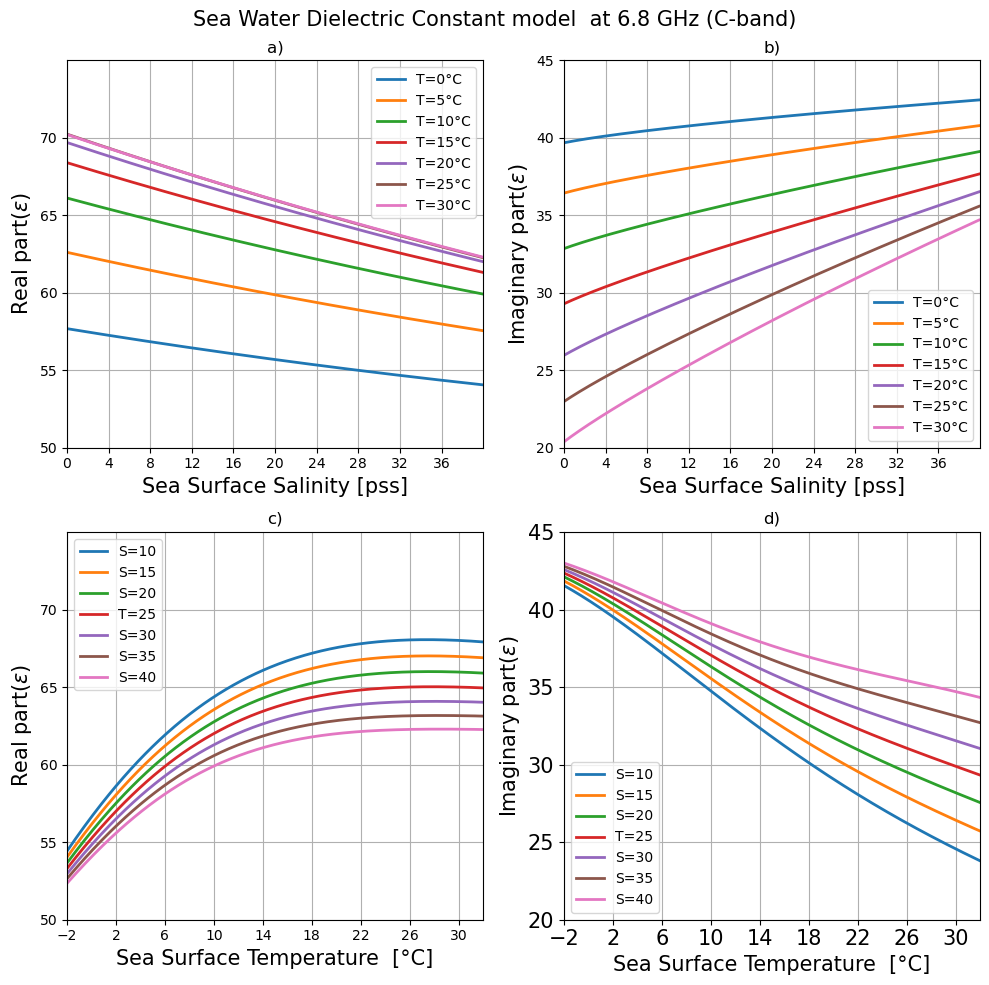

In [7]:
# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

f = 6.8

test = cdiel_cimr(So, To, f)
real_epsilon_C0 = test.real
imag_epsilon_C0 = test.imag

test = cdiel_cimr(So, T1,f)
real_epsilon_C1 = test.real
imag_epsilon_C1 = test.imag

test = cdiel_cimr(So, T2, f)
real_epsilon_C2 = test.real
imag_epsilon_C2 = test.imag

test = cdiel_cimr(So, T3, f)
real_epsilon_C3 = test.real
imag_epsilon_C3 = test.imag

test = cdiel_cimr(So, T4, f)
real_epsilon_C4 = test.real
imag_epsilon_C4 = test.imag

test = cdiel_cimr(So, T5, f)
real_epsilon_C5 = test.real
imag_epsilon_C5 = test.imag

test = cdiel_cimr(So, T6, f)
real_epsilon_C6 = test.real
imag_epsilon_C6 = test.imag


fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Sea Water Dielectric Constant model  at 6.8 GHz (C-band)',fontsize=15)
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,np.transpose(real_epsilon_C0), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C1), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C2), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C3), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C4), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C5), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels

ax1.axis([0, 40, 50, 75])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax1.set_title('a)')
ax1.set_xticks(np.arange(0, 40, 4))
ax1.set_yticks(np.arange(50, 75, 5))
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best')

ax2.plot(So,np.transpose(-imag_epsilon_C0), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C1), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C2), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C3), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C4), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C5), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 20, 45])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax2.set_title('b)')
ax2.set_xticks(np.arange(0, 40, 4))
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best')

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 40, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40

test = cdiel_cimr(So, To, f)
real_epsilon_C7 = test.real
imag_epsilon_C7 = test.imag

test = cdiel_cimr(S1, To, f)
real_epsilon_C8 = test.real
imag_epsilon_C8 = test.imag

test = cdiel_cimr(S2, To, f)
real_epsilon_C9 = test.real
imag_epsilon_C9 = test.imag

test = cdiel_cimr(S3, To, f)
real_epsilon_C10 = test.real
imag_epsilon_C10 = test.imag

test = cdiel_cimr(S4, To, f)
real_epsilon_C11 = test.real
imag_epsilon_C11 = test.imag

test = cdiel_cimr(S5, To, f)
real_epsilon_C12 = test.real
imag_epsilon_C12 = test.imag

test = cdiel_cimr(S6, To, f)
real_epsilon_C13 = test.real
imag_epsilon_C13 = test.imag


ax3.plot(To-273.15,np.transpose(real_epsilon_C7), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C8), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C9), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C10), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C11), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C12), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax3.axis([0, 32, 50, 75])
ax3.set_yticks(np.arange(50, 75, 5))
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax3.set_title('c)')
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best')

ax4.plot(To-273.15,np.transpose(-imag_epsilon_C7), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C8), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C9), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C10), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C11), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C12), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax4.axis([0, 32, 20, 45])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax4.set_title('d)')
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid()
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best')
plt.rc('axes', labelsize=15)        # Controls Axes Labels
#plt.axes(labelsize=10)        # Controls Axes Labels
plt.rc('xtick', labelsize=15)       # Controls x Tick Labels
plt.rc('ytick', labelsize=15)       # Controls y Tick Labels

fig1.tight_layout()

#for ax in fig1.get_axes():
#    ax.label_outer()  


In the following, the real and imaginary parts of the sea water dielectric constant model of Meissner and Wentz (2004,2012) at X-band are plotted as a function of S and T

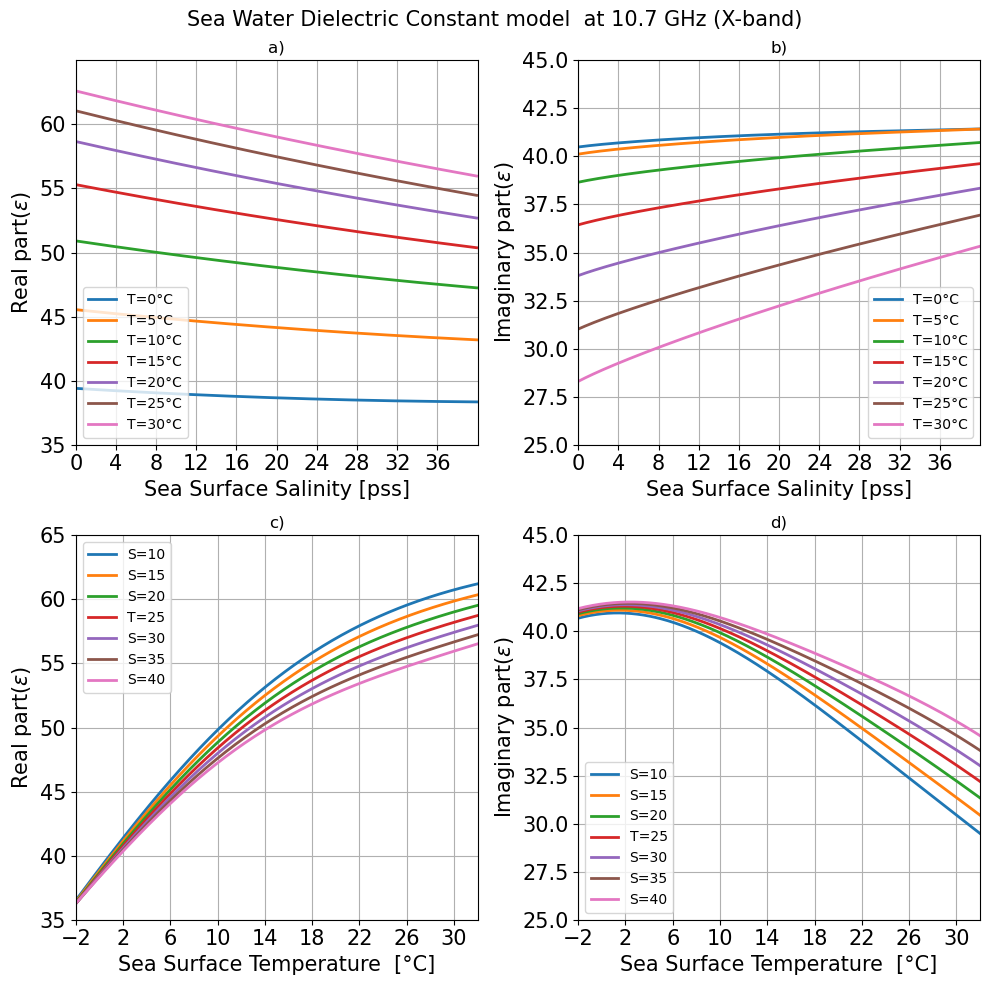

In [8]:
# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

f = 10.7

test = cdiel_cimr(So, To, f)
real_epsilon_C0 = test.real
imag_epsilon_C0 = test.imag

test = cdiel_cimr(So, T1,f)
real_epsilon_C1 = test.real
imag_epsilon_C1 = test.imag

test = cdiel_cimr(So, T2, f)
real_epsilon_C2 = test.real
imag_epsilon_C2 = test.imag

test = cdiel_cimr(So, T3, f)
real_epsilon_C3 = test.real
imag_epsilon_C3 = test.imag

test = cdiel_cimr(So, T4, f)
real_epsilon_C4 = test.real
imag_epsilon_C4 = test.imag

test = cdiel_cimr(So, T5, f)
real_epsilon_C5 = test.real
imag_epsilon_C5 = test.imag

test = cdiel_cimr(So, T6, f)
real_epsilon_C6 = test.real
imag_epsilon_C6 = test.imag


fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig3.suptitle('Sea Water Dielectric Constant model  at 10.7 GHz (X-band)',fontsize=15)
fig3.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,np.transpose(real_epsilon_C0), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C1), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C2), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C3), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C4), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C5), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 35, 65])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax1.set_title('a)')
ax1.set_xticks(np.arange(0, 40, 4))
ax1.set_yticks(np.arange(35, 65, 5))
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best')

ax2.plot(So,np.transpose(-imag_epsilon_C0), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C1), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C2), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C3), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C4), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C5), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 25, 45])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax2.set_title('b)')
ax2.set_xticks(np.arange(0, 40, 4))
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best')

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 40, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40

test = cdiel_cimr(So, To, f)
real_epsilon_C7 = test.real
imag_epsilon_C7 = test.imag

test = cdiel_cimr(S1, To, f)
real_epsilon_C8 = test.real
imag_epsilon_C8 = test.imag

test = cdiel_cimr(S2, To, f)
real_epsilon_C9 = test.real
imag_epsilon_C9 = test.imag

test = cdiel_cimr(S3, To, f)
real_epsilon_C10 = test.real
imag_epsilon_C10 = test.imag

test = cdiel_cimr(S4, To, f)
real_epsilon_C11 = test.real
imag_epsilon_C11 = test.imag

test = cdiel_cimr(S5, To, f)
real_epsilon_C12 = test.real
imag_epsilon_C12 = test.imag

test = cdiel_cimr(S6, To, f)
real_epsilon_C13 = test.real
imag_epsilon_C13 = test.imag


ax3.plot(To-273.15,np.transpose(real_epsilon_C7), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C8), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C9), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C10), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C11), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C12), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 35, 65])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax3.set_title('c)')
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best')

ax4.plot(To-273.15,np.transpose(-imag_epsilon_C7), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C8), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C9), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C10), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C11), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C12), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 25, 45])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax4.set_title('d)')
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid()
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best')
plt.rc('axes', labelsize=15)        # Controls Axes Labels
#plt.axes(labelsize=10)        # Controls Axes Labels
plt.rc('xtick', labelsize=15)       # Controls x Tick Labels
plt.rc('ytick', labelsize=15)       # Controls y Tick Labels

fig3.tight_layout()


In the following, the real and imaginary parts of the sea water dielectric constant model of Meissner and Wentz (2004,2012) at **Ku-band** are plotted as a function of S and T

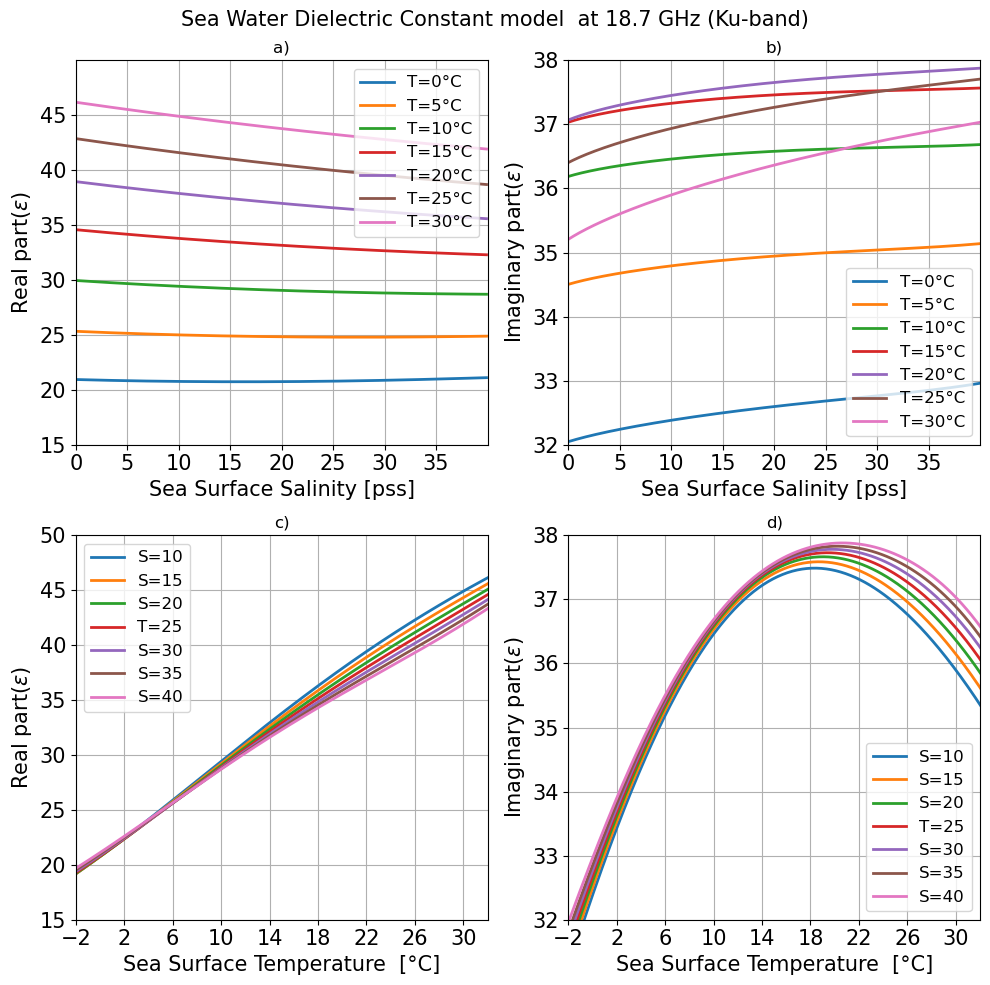

In [9]:
######################################################################################
# Plot the dielectric constant over S and T ranges at the CIMR Ku-band frequency      #
######################################################################################

# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

f = 18.7

test = cdiel_cimr(So, To, f)
real_epsilon_C0 = test.real
imag_epsilon_C0 = test.imag

test = cdiel_cimr(So, T1,f)
real_epsilon_C1 = test.real
imag_epsilon_C1 = test.imag

test = cdiel_cimr(So, T2, f)
real_epsilon_C2 = test.real
imag_epsilon_C2 = test.imag

test = cdiel_cimr(So, T3, f)
real_epsilon_C3 = test.real
imag_epsilon_C3 = test.imag

test = cdiel_cimr(So, T4, f)
real_epsilon_C4 = test.real
imag_epsilon_C4 = test.imag

test = cdiel_cimr(So, T5, f)
real_epsilon_C5 = test.real
imag_epsilon_C5 = test.imag

test = cdiel_cimr(So, T6, f)
real_epsilon_C6 = test.real
imag_epsilon_C6 = test.imag


fig4, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig4.suptitle('Sea Water Dielectric Constant model  at 18.7 GHz (Ku-band)',fontsize=15)
fig4.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,np.transpose(real_epsilon_C0), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C1), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C2), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C3), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C4), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C5), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 15, 50])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax1.set_title('a)')
ax1.set_xticks(np.arange(0, 40, 5))
ax1.set_yticks(np.arange(15, 50, 5))
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

ax2.plot(So,np.transpose(-imag_epsilon_C0), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C1), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C2), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C3), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C4), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C5), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 32, 38])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax2.set_title('b)')
ax2.set_xticks(np.arange(0, 40, 5))
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 40, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40

test = cdiel_cimr(So, To, f)
real_epsilon_C7 = test.real
imag_epsilon_C7 = test.imag

test = cdiel_cimr(S1, To, f)
real_epsilon_C8 = test.real
imag_epsilon_C8 = test.imag

test = cdiel_cimr(S2, To, f)
real_epsilon_C9 = test.real
imag_epsilon_C9 = test.imag

test = cdiel_cimr(S3, To, f)
real_epsilon_C10 = test.real
imag_epsilon_C10 = test.imag

test = cdiel_cimr(S4, To, f)
real_epsilon_C11 = test.real
imag_epsilon_C11 = test.imag

test = cdiel_cimr(S5, To, f)
real_epsilon_C12 = test.real
imag_epsilon_C12 = test.imag

test = cdiel_cimr(S6, To, f)
real_epsilon_C13 = test.real
imag_epsilon_C13 = test.imag


ax3.plot(To-273.15,np.transpose(real_epsilon_C7), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C8), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C9), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C10), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C11), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C12), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax3.axis([0, 32, 15, 50])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax3.set_title('c)')
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C7), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C8), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C9), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C10), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C11), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C12), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 32, 38])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax4.set_title('d)')
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid()
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
plt.rc('axes', labelsize=15)        # Controls Axes Labels
#plt.axes(labelsize=10)        # Controls Axes Labels
plt.rc('xtick', labelsize=10)       # Controls x Tick Labels
plt.rc('ytick', labelsize=10)       # Controls y Tick Labels
fig4.tight_layout()


In the following, the real and imaginery parts of the sea water dielectric constant model of Meissner and Wentz (2004,2012) at **Ka-band** are plotted as a function of S and T

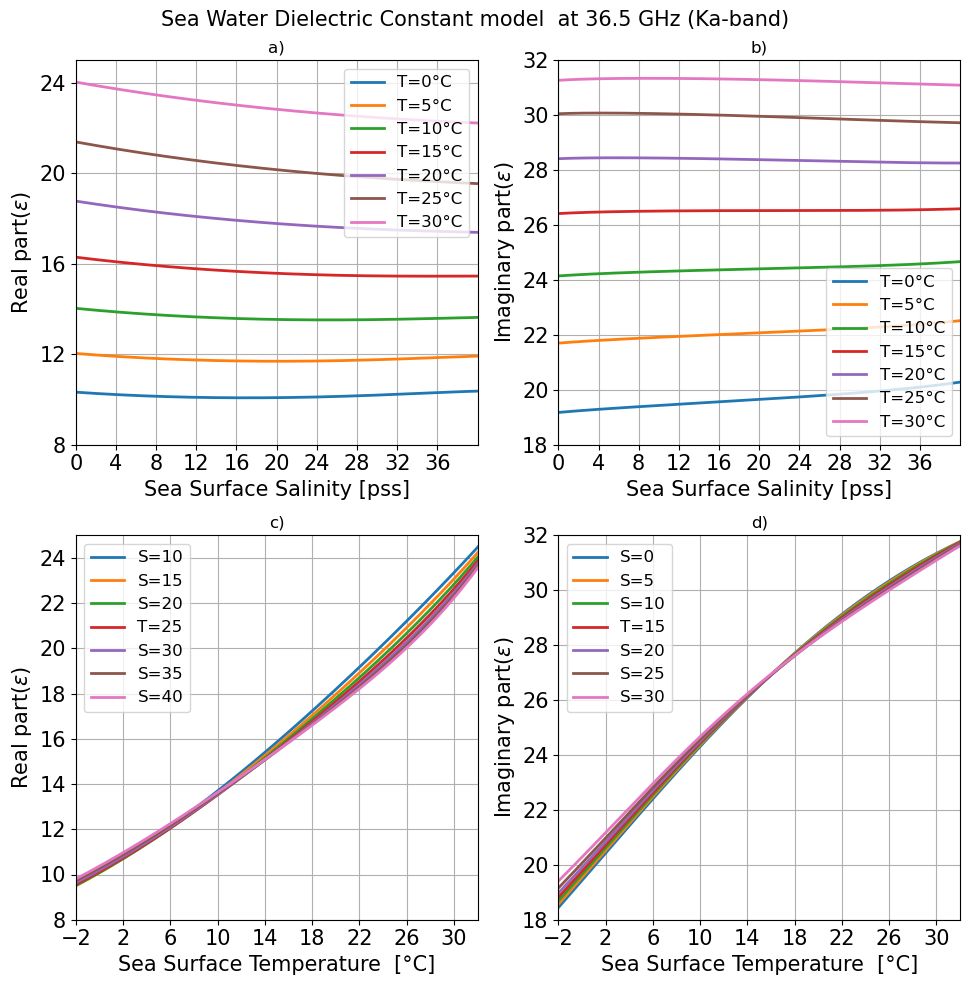

In [10]:
######################################################################################
# Plot the dielectric constant over S and T ranges at the CIMR Ka-band frequency      #
######################################################################################

# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

f = 36.5

test = cdiel_cimr(So, To, f)
real_epsilon_C0 = test.real
imag_epsilon_C0 = test.imag

test = cdiel_cimr(So, T1,f)
real_epsilon_C1 = test.real
imag_epsilon_C1 = test.imag

test = cdiel_cimr(So, T2, f)
real_epsilon_C2 = test.real
imag_epsilon_C2 = test.imag

test = cdiel_cimr(So, T3, f)
real_epsilon_C3 = test.real
imag_epsilon_C3 = test.imag

test = cdiel_cimr(So, T4, f)
real_epsilon_C4 = test.real
imag_epsilon_C4 = test.imag

test = cdiel_cimr(So, T5, f)
real_epsilon_C5 = test.real
imag_epsilon_C5 = test.imag

test = cdiel_cimr(So, T6, f)
real_epsilon_C6 = test.real
imag_epsilon_C6 = test.imag


fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Sea Water Dielectric Constant model  at 36.5 GHz (Ka-band)',fontsize=15)
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,np.transpose(real_epsilon_C0), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C1), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C2), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C3), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C4), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C5), '-', linewidth=2)
ax1.plot(So,np.transpose(real_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 8, 25])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax1.set_title('a)')
ax1.set_xticks(np.arange(0, 40, 4))
ax1.set_yticks(np.arange(8, 25, 4))
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

ax2.plot(So,np.transpose(-imag_epsilon_C0), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C1), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C2), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C3), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C4), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C5), '-', linewidth=2)
ax2.plot(So,np.transpose(-imag_epsilon_C6), '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 18, 32])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax2.set_title('b)')
ax2.set_xticks(np.arange(0, 40, 4))
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 40, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40

test = cdiel_cimr(So, To, f)
real_epsilon_C7 = test.real
imag_epsilon_C7 = test.imag

test = cdiel_cimr(S1, To, f)
real_epsilon_C8 = test.real
imag_epsilon_C8 = test.imag

test = cdiel_cimr(S2, To, f)
real_epsilon_C9 = test.real
imag_epsilon_C9 = test.imag

test = cdiel_cimr(S3, To, f)
real_epsilon_C10 = test.real
imag_epsilon_C10 = test.imag

test = cdiel_cimr(S4, To, f)
real_epsilon_C11 = test.real
imag_epsilon_C11 = test.imag

test = cdiel_cimr(S5, To, f)
real_epsilon_C12 = test.real
imag_epsilon_C12 = test.imag

test = cdiel_cimr(S6, To, f)
real_epsilon_C13 = test.real
imag_epsilon_C13 = test.imag


ax3.plot(To-273.15,np.transpose(real_epsilon_C7), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C8), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C9), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C10), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C11), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C12), '-', linewidth=2)
ax3.plot(To-273.15,np.transpose(real_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 8, 25])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Real part($\u03B5$)',fontsize=15)
ax3.set_title('c)')
ax3.set_xticks(np.arange(-2, 32, 4))
ax1.set_yticks(np.arange(8, 25, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)


ax4.plot(To-273.15,np.transpose(-imag_epsilon_C7), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C8), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C9), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C10), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C11), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C12), '-', linewidth=2)
ax4.plot(To-273.15,np.transpose(-imag_epsilon_C13), '-', linewidth=2)
# Set axis limits and labels
ax4.axis([0, 32, 18, 32])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Imaginary part($\u03B5$)',fontsize=15)
ax4.set_title('d)')
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid()
ax4.legend(['S=0','S=5','S=10','T=15','S=20','S=25','S=30','S=35'],loc='best',fontsize=12)
plt.rc('axes', labelsize=10)        # Controls Axes Labels
#plt.axes(labelsize=10)        # Controls Axes Labels
plt.rc('xtick', labelsize=15)       # Controls x Tick Labels
plt.rc('ytick', labelsize=15)       # Controls y Tick Labels

fig1.tight_layout()


## Brightness Temperature of a perfectly flat Sea Surface

Here we provide the codes to evaluate the Brightness temperature emitted by a perfectly flat sea surface at all CIMR frequencies and EIA

##############################################################

## **specular_sea_emission(S, T, theta, f) [real]**  

Computes the **brightness temperature** of a perfectly flat sea water surface with the following inputs:

### **Inputs**  
- **Salinity S** (*Sea water surface salinity*) **[pss]**  
- **Temperature T** (*Sea water surface temperature*) **[K]**  
- **Earth incidence angle theta** **[rad]** *(as observed by a radiometer)*  
- **Electromagnetic frequency f** **[Hz]** *(operating frequency of the radiometer)*  

### **Outputs**  
- **T_spec_v**: Brightness temperature of a perfectly flat sea surface in **V-polarization** **[K]**  
- **T_spec_h**: Brightness temperature of a perfectly flat sea surface in **H-polarization** **[K]**  

---

### **References**  
**Peake, William (1959).**  
*Interaction of electromagnetic waves with some natural surfaces.*  
IRE Transactions on Antennas and Propagation, **7(5)**:324-329.  

---

### **Note:**  
This code **uses the subfunction** `cdiel_cimr`, which evaluates the **complex sea water dielectric constant**  
for a given **salinity (S)**, **temperature (T)**, and **electromagnetic frequency (f)**.  

---

📌 **Code written by**: **Reul N. @ Ifremer**  
📅 **March 2023**  

##############################################################

In [11]:
def specular_sea_emission(S, T, theta, f):

# 1) Evaluate the complex sea water dielectric constant
#    for salinity S, temperature T and electromagnetic     
#    frequency f.
   if f < 2*1e9 :
    epsilon = cdiel_cimr_L(S, T)
   else :
    epsilon = cdiel_cimr(S, T, f*1e-9) 

   i = 1j
# 2) Evaluate the Fresnel Reflection coefficients in H and V polarizations from  sea water dielectric constant
#    epsilon [complex] and radiometer incidence angle theta [rad]

   Rh = (np.cos(theta) - np.sqrt(epsilon - np.sin(theta) ** 2)) / (np.cos(theta) + np.sqrt(epsilon - np.sin(theta) ** 2))
   Rv = (epsilon * np.cos(theta) - np.sqrt(epsilon - np.sin(theta) ** 2)) / (epsilon * np.cos(theta) + np.sqrt(epsilon - np.sin(theta) ** 2))

# 2) Evaluate the the brightness temperature of a perfectly flat sea water in vertical (v) and horizontal (h) polarization

   T_spec_v = T * (1 - np.abs(Rv) ** 2)
   T_spec_h = T * (1 - np.abs(Rh) ** 2)

   return T_spec_v, T_spec_h


In the following, we plot the perfectly flat sea surface brightness temperature emitted at L-band as a function of S and T, and at EIA=51.9°

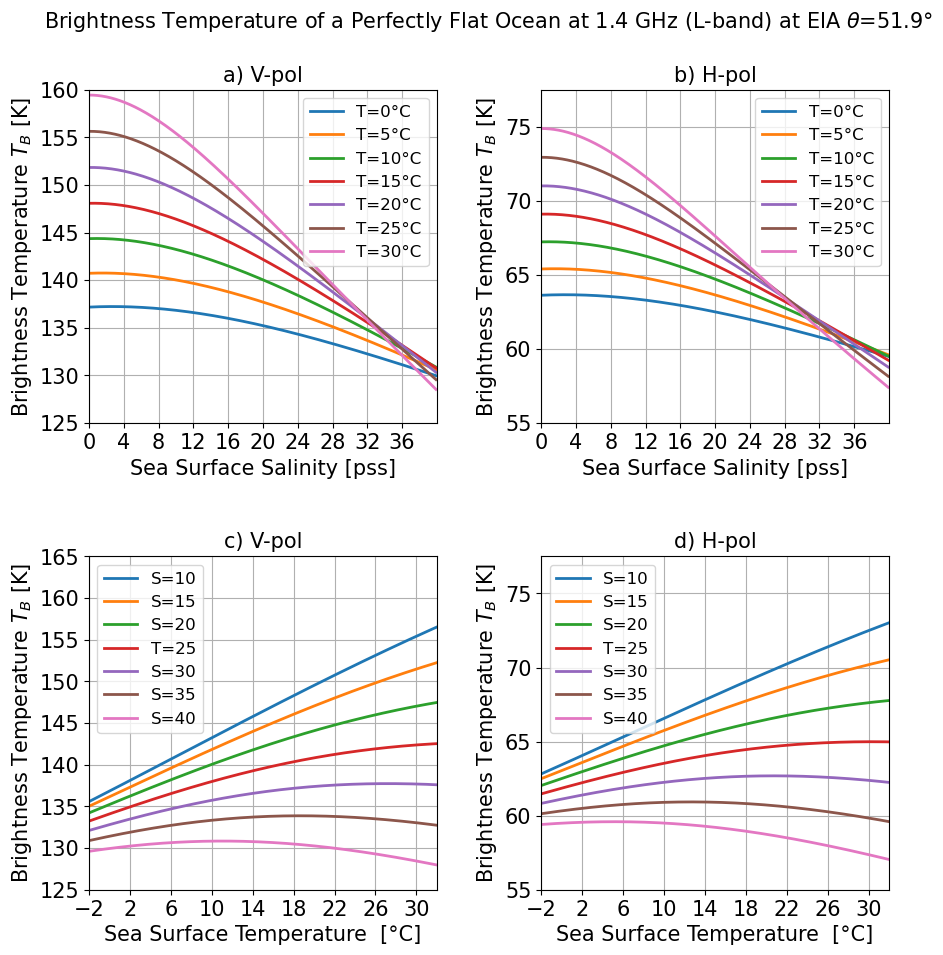

In [12]:
######################################################################################
# Plot the dielectric constant over S and T ranges at the CIMR Ka-band frequency      #
######################################################################################

# Vectors of Sea Surface salinity So and Temperature To [K]
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15


fL=1.4e9
thetaL=51.9 * np.pi/180


[T_spec_vo, T_spec_ho]=specular_sea_emission(So, To, thetaL, fL)
[T_spec_v1, T_spec_h1]=specular_sea_emission(So, T1, thetaL, fL)
[T_spec_v2, T_spec_h2]=specular_sea_emission(So, T2, thetaL, fL)
[T_spec_v3, T_spec_h3]=specular_sea_emission(So, T3, thetaL, fL)
[T_spec_v4, T_spec_h4]=specular_sea_emission(So, T4, thetaL, fL)
[T_spec_v5, T_spec_h5]=specular_sea_emission(So, T5, thetaL, fL)
[T_spec_v6, T_spec_h6]=specular_sea_emission(So, T6, thetaL, fL)

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Brightness Temperature of a Perfectly Flat Ocean at 1.4 GHz (L-band) at EIA $\u03B8$=51.9°',fontsize=15)
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,T_spec_vo[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v1[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v2[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v3[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v4[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v5[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 125, 160])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax1.set_title('a) V-pol',fontsize=15)
ax1.set_xticks(np.arange(0, 40, 4))
#ax1.set_yticks(np.arange(30, 70, 5))
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

ax2.plot(So,T_spec_ho[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h1[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h2[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h3[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h4[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h5[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 55, 77.5])
ax2.set_xticks(np.arange(0, 40, 4))
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax2.set_title('b) H-pol',fontsize=15)
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 40, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40



[T_spec_v7, T_spec_h7]=specular_sea_emission(So, To, thetaL, fL)
[T_spec_v8, T_spec_h8]=specular_sea_emission(S1, To, thetaL, fL)
[T_spec_v9, T_spec_h9]=specular_sea_emission(S2, To, thetaL, fL)
[T_spec_v10, T_spec_h10]=specular_sea_emission(S3, To, thetaL, fL)
[T_spec_v11, T_spec_h11]=specular_sea_emission(S4, To, thetaL, fL)
[T_spec_v12, T_spec_h12]=specular_sea_emission(S5, To, thetaL, fL)
[T_spec_v13, T_spec_h13]=specular_sea_emission(S6, To, thetaL, fL)

ax3.plot(To-273.15,T_spec_v7[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v8[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v9[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v10[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v11[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v12[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 125, 165])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax3.set_title('c) V-pol',fontsize=15)
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

ax4.plot(To-273.15,T_spec_h7[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h8[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h9[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h10[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h11[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h12[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 55, 77.5])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax4.set_title('d) H-pol',fontsize=15)
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.grid()
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
plt.show()



In the following we plot the perfectly flat sea surface brightness temperature at C-band and radiometer EIA=55°

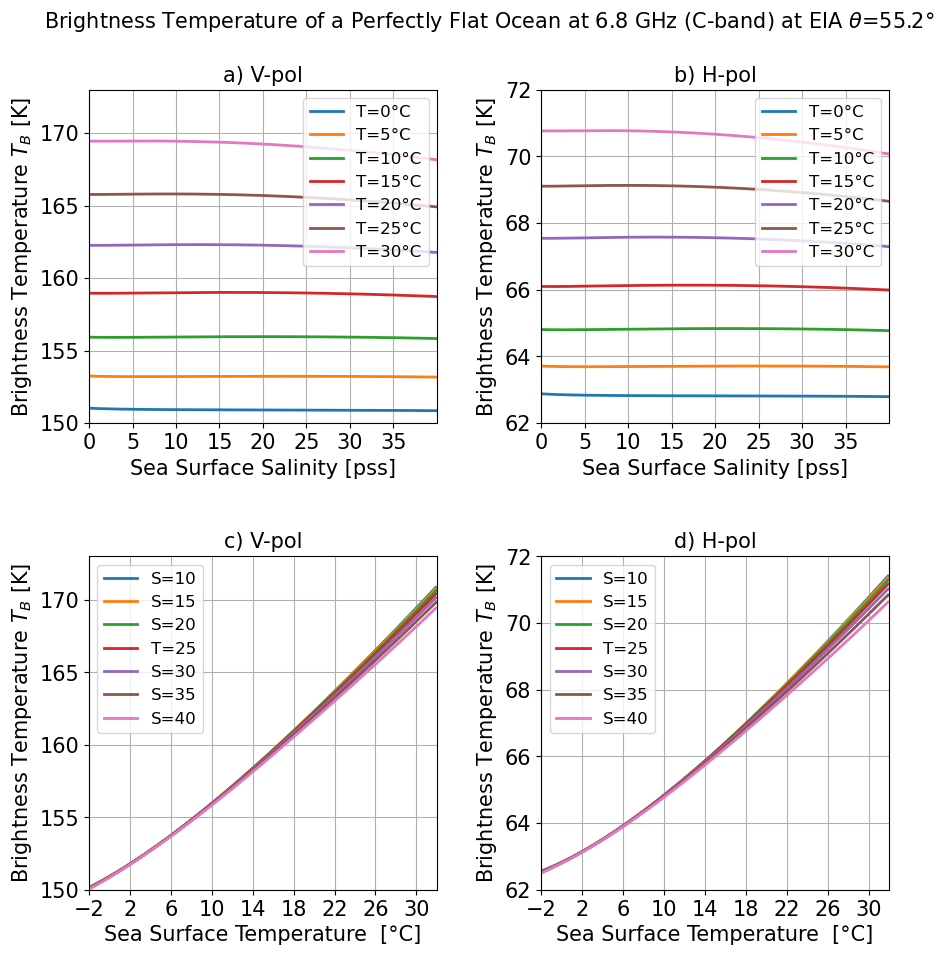

In [13]:
######################################################################################
# Plot the dielectric constant over S and T ranges at the CIMR Ka-band frequency      #
######################################################################################

# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

fL=6.8e9
thetaL=55.2 * np.pi/180

[T_spec_vo, T_spec_ho]=specular_sea_emission(So, To, thetaL, fL)
[T_spec_v1, T_spec_h1]=specular_sea_emission(So, T1, thetaL, fL)
[T_spec_v2, T_spec_h2]=specular_sea_emission(So, T2, thetaL, fL)
[T_spec_v3, T_spec_h3]=specular_sea_emission(So, T3, thetaL, fL)
[T_spec_v4, T_spec_h4]=specular_sea_emission(So, T4, thetaL, fL)
[T_spec_v5, T_spec_h5]=specular_sea_emission(So, T5, thetaL, fL)
[T_spec_v6, T_spec_h6]=specular_sea_emission(So, T6, thetaL, fL)

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Brightness Temperature of a Perfectly Flat Ocean at 6.8 GHz (C-band) at EIA $\u03B8$=55.2°',fontsize=15)
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,T_spec_vo[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v1[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v2[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v3[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v4[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v5[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 150, 173])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax1.set_title('a) V-pol',fontsize=15)
ax1.set_xticks(np.arange(0, 40, 5))
#ax1.set_yticks(np.arange(30, 70, 5))
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

ax2.plot(So,T_spec_ho[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h1[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h2[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h3[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h4[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h5[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 62, 72])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax2.set_title('b) H-pol',fontsize=15)
ax2.set_xticks(np.arange(0, 40, 5))
#ax1.set_yticks(np.arange(30, 70, 5))
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 32, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40



[T_spec_v7, T_spec_h7]=specular_sea_emission(So, To, thetaL, fL)
[T_spec_v8, T_spec_h8]=specular_sea_emission(S1, To, thetaL, fL)
[T_spec_v9, T_spec_h9]=specular_sea_emission(S2, To, thetaL, fL)
[T_spec_v10, T_spec_h10]=specular_sea_emission(S3, To, thetaL, fL)
[T_spec_v11, T_spec_h11]=specular_sea_emission(S4, To, thetaL, fL)
[T_spec_v12, T_spec_h12]=specular_sea_emission(S5, To, thetaL, fL)
[T_spec_v13, T_spec_h13]=specular_sea_emission(S6, To, thetaL, fL)

ax3.plot(To-273.15,T_spec_v7[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v8[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v9[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v10[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v11[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v12[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 150, 173])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax3.set_title('c) V-pol',fontsize=15)
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

ax4.plot(To-273.15,T_spec_h7[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h8[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h9[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h10[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h11[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h12[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 62, 72])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax4.set_title('d) H-pol',fontsize=15)
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.grid()
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
plt.rc('axes', labelsize=10)        # Controls Axes Labels
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
# set the spacing between subplots
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
plt.show()

#plt.axes(labelsize=10)        # Controls Axes Labels
plt.rc('xtick', labelsize=10)       # Controls x Tick Labels
plt.rc('ytick', labelsize=10)       # Controls y Tick Labels
fig1.tight_layout()


In the following we plot the perfectly flat sea surface brightness temperature at X-band as a function of S & T and at radiometer EIA=55°

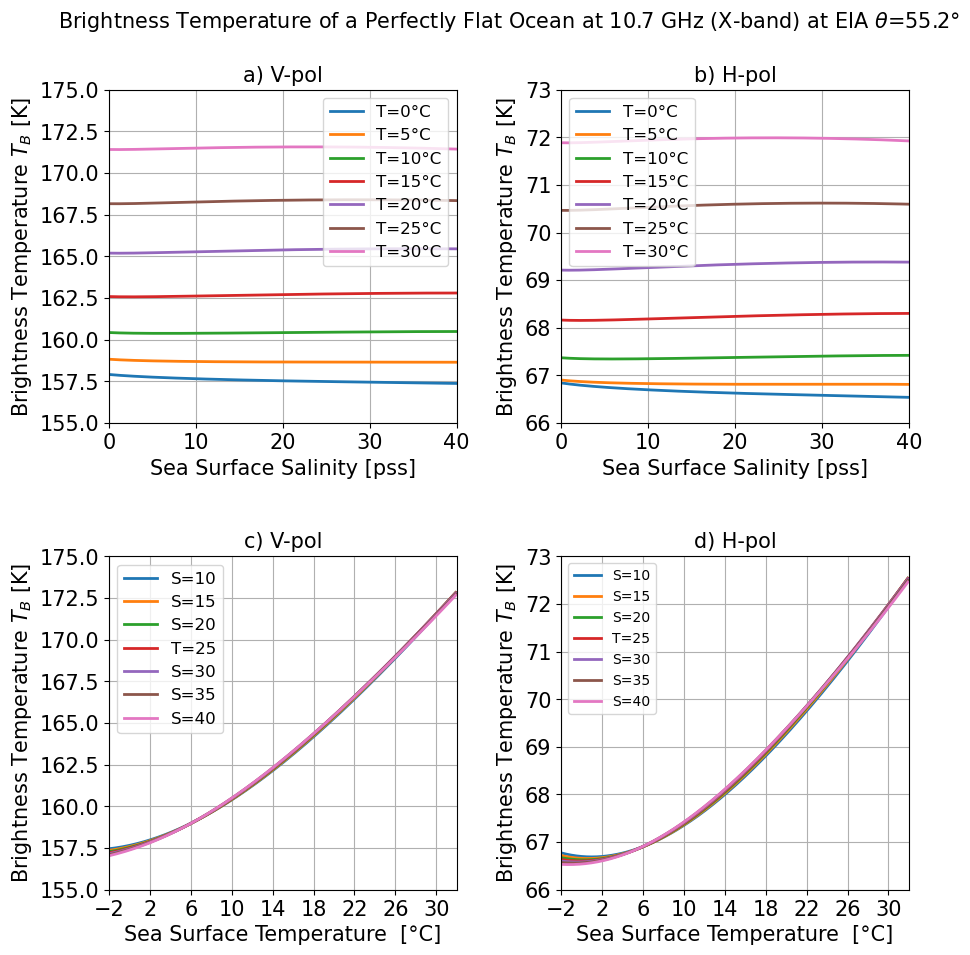

In [14]:
######################################################################################
# Plot the dielectric constant over S and T ranges at the CIMR Ka-band frequency      #
######################################################################################

# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

fL=10.7e9
thetaL=55.2 * np.pi/180

[T_spec_vo, T_spec_ho]=specular_sea_emission(So, To, thetaL, fL)
[T_spec_v1, T_spec_h1]=specular_sea_emission(So, T1, thetaL, fL)
[T_spec_v2, T_spec_h2]=specular_sea_emission(So, T2, thetaL, fL)
[T_spec_v3, T_spec_h3]=specular_sea_emission(So, T3, thetaL, fL)
[T_spec_v4, T_spec_h4]=specular_sea_emission(So, T4, thetaL, fL)
[T_spec_v5, T_spec_h5]=specular_sea_emission(So, T5, thetaL, fL)
[T_spec_v6, T_spec_h6]=specular_sea_emission(So, T6, thetaL, fL)

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Brightness Temperature of a Perfectly Flat Ocean at 10.7 GHz (X-band) at EIA $\u03B8$=55.2°',fontsize=15)
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,T_spec_vo[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v1[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v2[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v3[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v4[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v5[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 155, 175])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax1.set_title('a) V-pol',fontsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

ax2.plot(So,T_spec_ho[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h1[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h2[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h3[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h4[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h5[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 66, 73])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax2.set_title('b) H-pol',fontsize=15)
#ax1.set_xticks(np.arange(0, 40, 4))
#ax1.set_yticks(np.arange(30, 70, 5))
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 32, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40



[T_spec_v7, T_spec_h7]=specular_sea_emission(So, To, thetaL, fL)
[T_spec_v8, T_spec_h8]=specular_sea_emission(S1, To, thetaL, fL)
[T_spec_v9, T_spec_h9]=specular_sea_emission(S2, To, thetaL, fL)
[T_spec_v10, T_spec_h10]=specular_sea_emission(S3, To, thetaL, fL)
[T_spec_v11, T_spec_h11]=specular_sea_emission(S4, To, thetaL, fL)
[T_spec_v12, T_spec_h12]=specular_sea_emission(S5, To, thetaL, fL)
[T_spec_v13, T_spec_h13]=specular_sea_emission(S6, To, thetaL, fL)

ax3.plot(To-273.15,T_spec_v7[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v8[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v9[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v10[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v11[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v12[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 155, 175])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax3.set_title('c) V-pol',fontsize=15)
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)

ax4.plot(To-273.15,T_spec_h7[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h8[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h9[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h10[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h11[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h12[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 66, 73])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax4.set_title('d) H-pol',fontsize=15)
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid()
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best')
# set the spacing between subplots
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
plt.show()


plt.rc('axes', labelsize=10)        # Controls Axes Labels
#plt.axes(labelsize=10)        # Controls Axes Labels
plt.rc('xtick', labelsize=10)       # Controls x Tick Labels
plt.rc('ytick', labelsize=10)       # Controls y Tick Labels

fig1.tight_layout()


In the following we plot the perfectly flat sea surface brightness temperature at Ku-band as a function of S & T and at radiometer EIA=55°

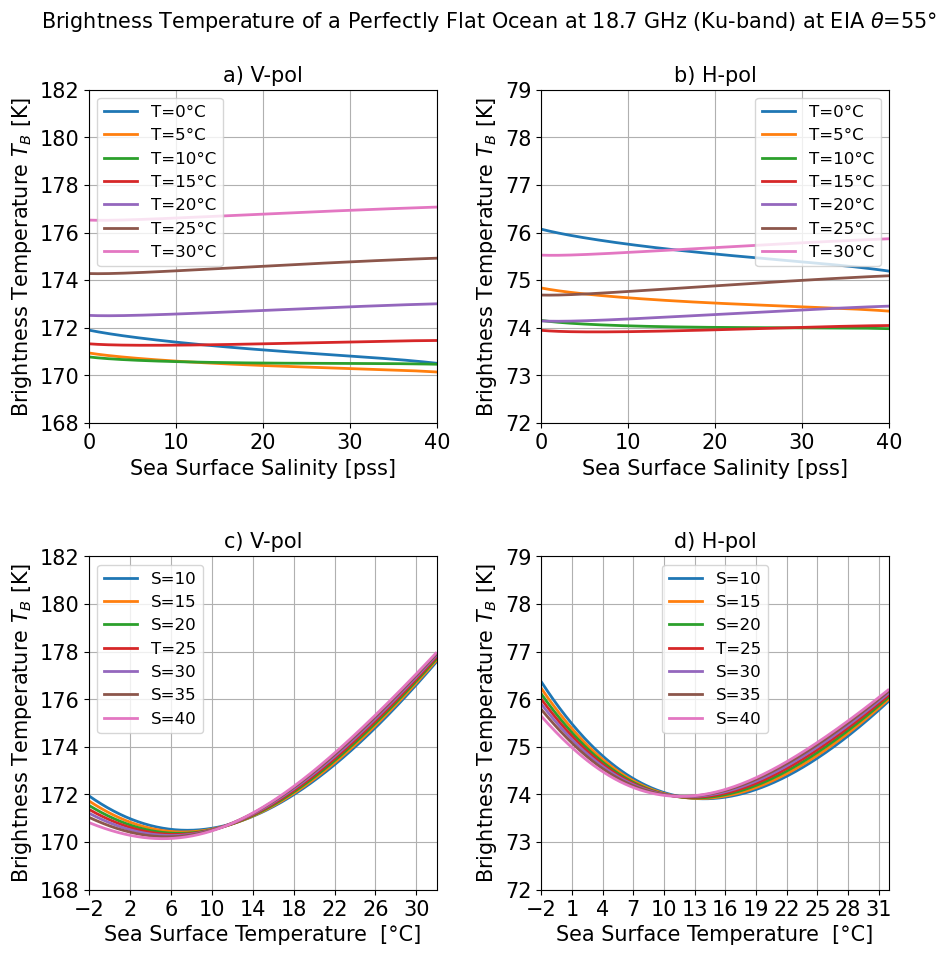

In [15]:
# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

fKu=18.7e9
thetaL=55 * np.pi/180

[T_spec_vo, T_spec_ho]=specular_sea_emission(So, To, thetaL, fKu)
[T_spec_v1, T_spec_h1]=specular_sea_emission(So, T1, thetaL, fKu)
[T_spec_v2, T_spec_h2]=specular_sea_emission(So, T2, thetaL, fKu)
[T_spec_v3, T_spec_h3]=specular_sea_emission(So, T3, thetaL, fKu)
[T_spec_v4, T_spec_h4]=specular_sea_emission(So, T4, thetaL, fKu)
[T_spec_v5, T_spec_h5]=specular_sea_emission(So, T5, thetaL, fKu)
[T_spec_v6, T_spec_h6]=specular_sea_emission(So, T6, thetaL, fKu)

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Brightness Temperature of a Perfectly Flat Ocean at 18.7 GHz (Ku-band) at EIA $\u03B8$=55°',fontsize=15)
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,T_spec_vo[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v1[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v2[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v3[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v4[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v5[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 168, 182])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax1.set_title('a) V-pol',fontsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
#ax1.set_xticks(np.arange(0, 40, 4))
#ax1.set_yticks(np.arange(30, 70, 5))
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

ax2.plot(So,T_spec_ho[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h1[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h2[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h3[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h4[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h5[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax2.axis([0, 40, 72, 79])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax2.set_title('b) H-pol',fontsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
#ax1.set_xticks(np.arange(0, 40, 4))
#ax1.set_yticks(np.arange(30, 70, 5))
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 32, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40



[T_spec_v7, T_spec_h7]=specular_sea_emission(So, To, thetaL, fKu)
[T_spec_v8, T_spec_h8]=specular_sea_emission(S1, To, thetaL, fKu)
[T_spec_v9, T_spec_h9]=specular_sea_emission(S2, To, thetaL, fKu)
[T_spec_v10, T_spec_h10]=specular_sea_emission(S3, To, thetaL, fKu)
[T_spec_v11, T_spec_h11]=specular_sea_emission(S4, To, thetaL, fKu)
[T_spec_v12, T_spec_h12]=specular_sea_emission(S5, To, thetaL, fKu)
[T_spec_v13, T_spec_h13]=specular_sea_emission(S6, To, thetaL, fKu)

ax3.plot(To-273.15,T_spec_v7[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v8[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v9[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v10[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v11[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v12[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 168, 182])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax3.set_title('c) V-pol',fontsize=15)
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)

ax4.plot(To-273.15,T_spec_h7[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h8[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h9[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h10[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h11[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h12[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 72, 79])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax4.set_title('d) H-pol',fontsize=15)
ax4.set_xticks(np.arange(-2, 32, 3))
ax4.grid()
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
# set the spacing between subplots
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
plt.show()


In the following we plot the perfectly flat sea surface brightness temperature at Ka-band as a function of S & T and at radiometer EIA=55°

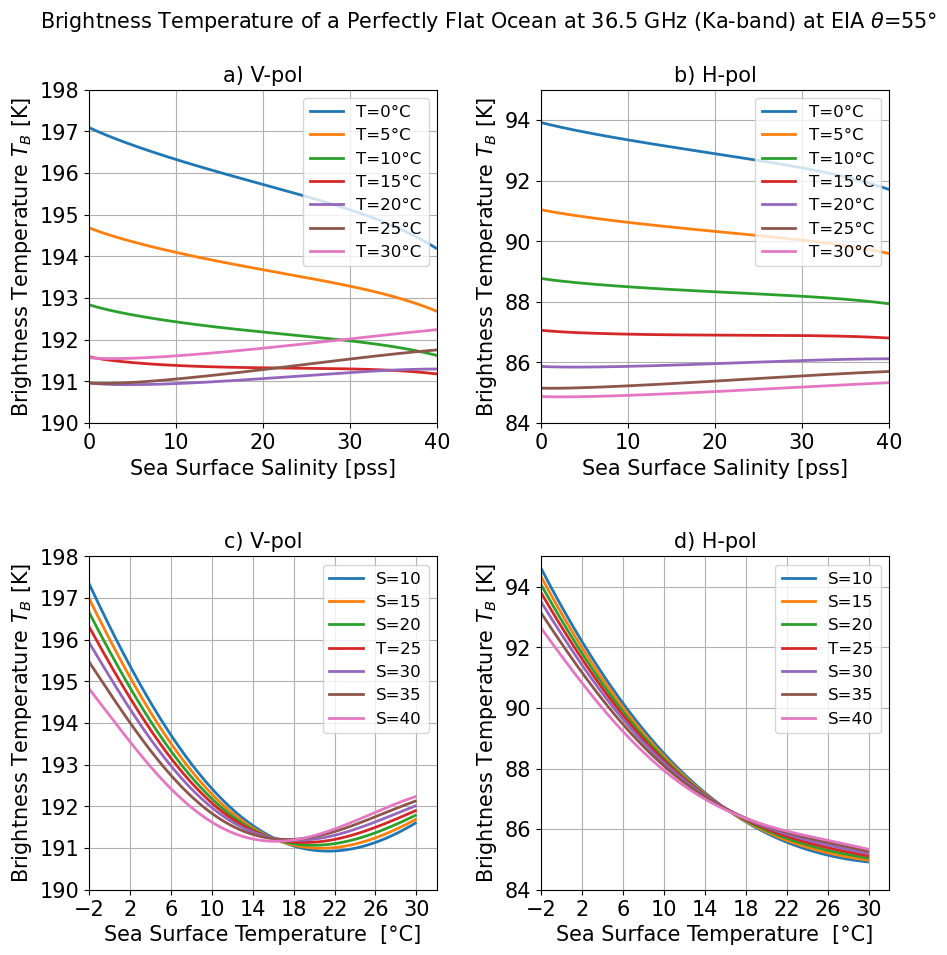

In [16]:
# Vectors of Sea Surface salinity So and Temperature To
So = np.arange(0, 40, 0.1)
To = 0+273.15
T1 = 5+273.15
T2 = 10+273.15
T3 = 15+273.15
T4 = 20+273.15
T5 = 25+273.15
T6 = 30+273.15

fKa=36.5e9
thetaKa=55 * np.pi/180

[T_spec_vo, T_spec_ho]=specular_sea_emission(So, To, thetaKa, fKa)
[T_spec_v1, T_spec_h1]=specular_sea_emission(So, T1, thetaKa, fKa)
[T_spec_v2, T_spec_h2]=specular_sea_emission(So, T2, thetaKa, fKa)
[T_spec_v3, T_spec_h3]=specular_sea_emission(So, T3, thetaKa, fKa)
[T_spec_v4, T_spec_h4]=specular_sea_emission(So, T4, thetaKa, fKa)
[T_spec_v5, T_spec_h5]=specular_sea_emission(So, T5, thetaKa, fKa)
[T_spec_v6, T_spec_h6]=specular_sea_emission(So, T6, thetaKa, fKa)

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Brightness Temperature of a Perfectly Flat Ocean at 36.5 GHz (Ka-band) at EIA $\u03B8$=55°',fontsize=15)
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(So,T_spec_vo[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v1[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v2[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v3[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v4[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v5[0,:], '-', linewidth=2)
ax1.plot(So,T_spec_v6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax1.axis([0, 40, 190, 198])
ax1.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax1.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax1.set_title('a) V-pol',fontsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.grid()
ax1.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

ax2.plot(So,T_spec_ho[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h1[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h2[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h3[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h4[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h5[0,:], '-', linewidth=2)
ax2.plot(So,T_spec_h6[0,:], '-', linewidth=2)
# Set axis limits and labels
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.axis([0, 40, 84, 95])
ax2.set_xlabel('Sea Surface Salinity [pss]',fontsize=15)
ax2.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax2.set_title('b) H-pol',fontsize=15)
ax2.grid()
ax2.legend(['T=0°C','T=5°C','T=10°C','T=15°C','T=20°C','T=25°C','T=30°C'],loc='best',fontsize=12)

# Vectors of Sea Surface salinity So and Temperature To
To = np.arange(-2, 30, 0.1)+273.15
So = 10
S1 = 15
S2 = 20
S3 = 25
S4 = 30
S5 = 35
S6 = 40



[T_spec_v7, T_spec_h7]=specular_sea_emission(So, To, thetaKa, fKa)
[T_spec_v8, T_spec_h8]=specular_sea_emission(S1, To, thetaKa, fKa)
[T_spec_v9, T_spec_h9]=specular_sea_emission(S2, To, thetaKa, fKa)
[T_spec_v10, T_spec_h10]=specular_sea_emission(S3, To, thetaKa, fKa)
[T_spec_v11, T_spec_h11]=specular_sea_emission(S4, To, thetaKa, fKa)
[T_spec_v12, T_spec_h12]=specular_sea_emission(S5, To, thetaKa, fKa)
[T_spec_v13, T_spec_h13]=specular_sea_emission(S6, To, thetaKa, fKa)

ax3.plot(To-273.15,T_spec_v7[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v8[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v9[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v10[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v11[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v12[0,:], '-', linewidth=2)
ax3.plot(To-273.15,T_spec_v13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax3.axis([-2, 32, 190, 198])
ax3.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax3.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax3.set_title('c) V-pol',fontsize=15)
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)
ax3.set_xticks(np.arange(-2, 32, 4))
ax3.grid()
ax3.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)

ax4.plot(To-273.15,T_spec_h7[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h8[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h9[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h10[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h11[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h12[0,:], '-', linewidth=2)
ax4.plot(To-273.15,T_spec_h13[0,:], '-', linewidth=2)
# Set axis limits and labels
ax4.axis([-2, 32, 84, 95])
ax4.set_xlabel('Sea Surface Temperature  [°C]',fontsize=15)
ax4.set_ylabel('Brightness Temperature $T_{B}$ [K]',fontsize=15)
ax4.set_title('d) H-pol',fontsize=15)
ax4.set_xticks(np.arange(-2, 32, 4))
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid()
ax4.legend(['S=10','S=15','S=20','T=25','S=30','S=35','S=40'],loc='best',fontsize=12)
# set the spacing between subplots
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
plt.show()


## Sea Surface Roughness-Induced Brightness temperature


The codes to evaluate the isotropic and anistropic components of roughness(wind)-induced Brightness Temperature contrast for all 4 Stokes parameters and for all CIMR frequencies are provided herebelow for the below tropical storm force wind (U_1017 m/s). Illustration are also given.


### Isotropic components of the wind-induced radio-brightness contrast T_B


In [17]:
##########################################################################################
#  This code evaluate & plot the low-to-moderate wind speed (0-17 m/s) wind-induced      #
#  emissivity azimuthal harmonic components using the CIMR's GMFs expressed in           #
#  https://cimr-algos.github.io/OceanWindVectors_ATBD/baseline_algorithm_definition.html #
#  for the 5 CIMR central frequencies: L (1.4 GHz), C (6.8 GHz), X (10.7 GHz),           #
#                             Ku (18.7 GHz) and Ka (36.5 GHz) bands                      #
#                                                                                        #
#           Code written by Reul.N    nicolas.reul@ifremer.fr                            #
#                                                                                        #
#                                 April 2023                                             #
# ########################################################################################


#############################################################
# 1) 10 meter height  Wind speed Vector from 0 to 17 m/s    #
#############################################################
#    Input Parameters
U10 = np.arange(0, 17.1, 0.1)

phi_r_deg = np.arange(0, 360, 10)
phi_r_rad = phi_r_deg * np.pi /180

lU = np.size(U10)                       #length of vector U10
lphi = np.size(phi_r_rad)               #length of vector phi_r

#    Transformation of U10 and phi_r into matrices [lUxlphi]

U10m = np.zeros((lU, lphi))
cosphim = np.zeros((lU, lphi))
cos2phim = np.zeros((lU, lphi))
sinphim = np.zeros((lU, lphi))
sin2phim = np.zeros((lU, lphi))



for i in range(lphi):
    U10m[:,i] = U10
    
    
for i in range(lU):
    cosphim[i,:] = np.cos(phi_r_rad)
    cos2phim[i,:] = np.cos(2 * phi_r_rad)
    sinphim[i,:] = np.sin(phi_r_rad)
    sin2phim[i,:] = np.sin(2 * phi_r_rad)


##############################################################################
# 2) Isotropic wind-induced emissivity component at the 5  CIMR frequencies  #
##############################################################################


# L-band isotropic coefficients (from table 3 in the ATBD)

delta_14v = [1.6097e-3, -2.6751e-4, 2.4483e-5, -8.6502e-7, 1.0749e-8]
delta_14h = [4.3588e-3, -5.8672e-4, 4.3997e-5, -1.4223e-6, 1.6548e-8]

Delta_e0_L_v = delta_14v[0] * U10 + delta_14v[1] * U10**2 + delta_14v[2] * U10**3 + delta_14v[3] * U10**4 + delta_14v[4] * U10**5
Delta_e0_L_h = delta_14h[0] * U10 + delta_14h[1] * U10**2 + delta_14h[2] * U10**3 + delta_14h[3] * U10**4 + delta_14h[4] * U10**5

# C-band isotropic coefficients (from table 3 in the ATBD)

delta_68v = [4.96726e-5, -3.03363e-4, 5.6050506e-5, -2.86408e-6, 4.88803e-8]
delta_68h = [3.85750e-3, -5.10844e-4, 4.89469e-5, -1.50552e-6, 1.200306e-8]

Delta_e0_C_v = delta_68v[0] * U10 + delta_68v[1] * U10**2 + delta_68v[2] * U10**3 + delta_68v[3] * U10**4 + delta_68v[4] * U10**5
Delta_e0_C_h = delta_68h[0] * U10 + delta_68h[1] * U10**2 + delta_68h[2] * U10**3 + delta_68h[3] * U10**4 + delta_68h[4] * U10**5

# X-band isotropic coefficients (from table 3 in the ATBD)

delta_107v = [-2.35464e-4, -2.76866e-4, 5.73583e-5, -2.94364e-6, 4.89421e-8]
delta_107h = [4.17650e-3, -6.20751e-4, 6.82607e-5, -2.47982e-6, 2.80155e-8]

Delta_e0_X_v = delta_107v[0] * U10 + delta_107v[1] * U10**2 + delta_107v[2] * U10**3 + delta_107v[3] * U10**4 + delta_107v[4] * U10**5
Delta_e0_X_h = delta_107h[0] * U10 + delta_107h[1] * U10**2 + delta_107h[2] * U10**3 + delta_107h[3] * U10**4 + delta_107h[4] * U10**5

# Ku-band isotropic polynomial coefficients (table 3 in the ATBD)

delta_187v = [3.26502e-5, -3.65935e-4, 6.62807e-5, -3.40705e-6, 5.81231e-8]
delta_187h = [5.06330e-3, -7.41324e-4, 8.54446e-5, -3.28225e-6, 4.01950e-8]

Delta_e0_Ku_v = delta_187v[0] * U10 + delta_187v[1] * U10**2 + delta_187v[2] * U10**3 + delta_187v[3] * U10**4 + delta_187v[4] * U10**5
Delta_e0_Ku_h = delta_187h[0] * U10 + delta_187h[1] * U10**2 + delta_187h[2] * U10**3 + delta_187h[3] * U10**4 + delta_187h[4] * U10**5

# Ka-band isotropic coefficients (table 3 in the ATBD)

delta_37v = [-7.03594e-4, -2.17673e-4, 4.00659e-5, -1.84769e-6, 2.76830e-8]
delta_37h = [5.63832e-3, -8.43744e-4, 1.06734e-4, -4.61253e-6, 6.67315e-8]

Delta_e0_Ka_v = delta_37v[0] * U10 + delta_37v[1] * U10**2 + delta_37v[2] * U10**3 + delta_37v[3] * U10**4 + delta_37v[4] * U10**5
Delta_e0_Ka_h = delta_37h[0] * U10 + delta_37h[1] * U10**2 + delta_37h[2] * U10**3 + delta_37h[3] * U10**4 + delta_37h[4] * U10**5


Here below, we provide a code to plot the isotropic wind-induced emissivity component at the 5 CIMR frequencies and reference incidence angles

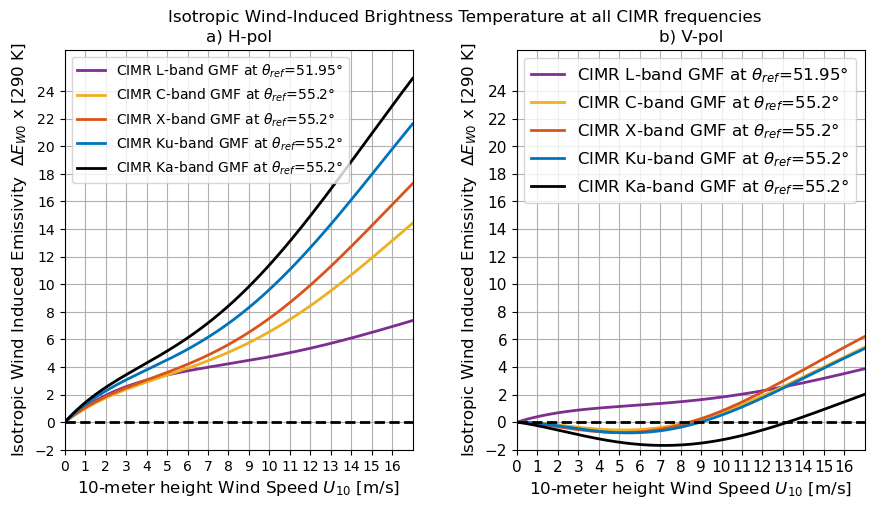

In [18]:

#######################################################################################################################################
# Create a figure for the H-pol isotropic wind-induced emissivity component at the 5  CIMR frequencies and reference incidence angles #
#######################################################################################################################################


fig1, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(10,5))
fig1.suptitle('Isotropic Wind-Induced Brightness Temperature at all CIMR frequencies')
fig1.gca().tick_params(axis='both', which='major', labelsize=15)

h1, = ax1.plot(U10, 290 * Delta_e0_L_h, '-', linewidth=2, color=[0.49, 0.18, 0.56])
h2, = ax1.plot(U10, 290 * Delta_e0_C_h, '-', linewidth=2, color=[0.93, 0.69, 0.13])
h3, = ax1.plot(U10, 290 * Delta_e0_X_h, '-', linewidth=2, color=[0.85, 0.33, 0.1])
h4, = ax1.plot(U10, 290 * Delta_e0_Ku_h, '-', linewidth=2, color=[0, 0.45, 0.74])
h5, = ax1.plot(U10, 290 * Delta_e0_Ka_h, '-', linewidth=2, color='k')
ax1.axis([0, 17, -2, 27])
ax1.set_xlabel('10-meter height Wind Speed $U_{10}$ [m/s]',fontsize=12)
ax1.set_ylabel('Isotropic Wind Induced Emissivity  $\u0394 E_{W0}$ x [290 K]',fontsize=12)
ax1.set_title('a) H-pol')
ax1.set_xticks(np.arange(0, 17, 1))
ax1.set_yticks(np.arange(-2, 26, 2))
ax1.grid()
ax1.axhline(0, linestyle='--', color='k', linewidth=2)
ax1.legend([h1, h2, h3, h4, h5],
           ['CIMR L-band GMF at $\u03B8_{ref}$=51.95°',
            'CIMR C-band GMF at $\u03B8_{ref}$=55.2°',
            'CIMR X-band GMF at $\u03B8_{ref}$=55.2°',
            'CIMR Ku-band GMF at $\u03B8_{ref}$=55.2°',
            'CIMR Ka-band GMF at $\u03B8_{ref}$=55.2°'],
           loc='best')

#######################################################################################################################################
# Create a figure for the V-pol isotropic wind-induced emissivity component at the 5  CIMR frequencies and reference incidence angles
#######################################################################################################################################

h1, = ax2.plot(U10, 290 * Delta_e0_L_v, '-', linewidth=2, color=[0.49, 0.18, 0.56])
h2, = ax2.plot(U10, 290 * Delta_e0_C_v, '-', linewidth=2, color=[0.93, 0.69, 0.13])
h3, = ax2.plot(U10, 290 * Delta_e0_X_v, '-', linewidth=2, color=[0.85, 0.33, 0.1])
h4, = ax2.plot(U10, 290 * Delta_e0_Ku_v, '-', linewidth=2, color=[0, 0.45, 0.74])
h5, = ax2.plot(U10, 290 * Delta_e0_Ka_v, '-', linewidth=2, color='k')

# Set axis limits and labels
ax2.axis([0, 17, -2, 27])
ax2.set_xlabel('10-meter height Wind Speed $U_{10}$ [m/s]',fontsize=12)
ax2.set_ylabel('Isotropic Wind Induced Emissivity  $\u0394 E_{W0}$ x [290 K]',fontsize=12)
ax2.set_title('b) V-pol')
ax2.set_xticks(np.arange(0, 17, 1))
ax2.set_yticks(np.arange(-2, 26, 2))
ax2.grid()
ax2.axhline(0, linestyle='--', color='k', linewidth=2)
ax2.legend([h1, h2, h3, h4, h5],
           ['CIMR L-band GMF at $\u03B8_{ref}$=51.95°',
            'CIMR C-band GMF at $\u03B8_{ref}$=55.2°',
            'CIMR X-band GMF at $\u03B8_{ref}$=55.2°',
            'CIMR Ku-band GMF at $\u03B8_{ref}$=55.2°',
            'CIMR Ka-band GMF at $\u03B8_{ref}$=55.2°'],
           loc='best',fontsize=12)
ax2.tick_params(axis='x', labelsize=11)
ax2.tick_params(axis='y', labelsize=11)
fig1.tight_layout()
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)
plt.show()

### Anisotropic components of the wind-induced Radio-Brightness Contrast T_B

In [19]:
######################################################
# 3) Anisotropic wind-induced emissivity components  #
######################################################


# 3.1) Coefficients for L-band
###############################

# 3.1.1) First azimuthal harmonic coefficients at L-band
########################################################


a1L_V = np.array([9.1197181127e-3/290, -3.0431623312e-3/290, 5.0839571367e-4/290, -2.0375986729e-5/290, 2.4580823525e-7/290])  # V-pol
a1L_H = np.array([9.6160121528e-3/290, -4.3505334225e-3/290, 6.0718079191e-4/290, -2.7536464802e-5/290, 4.0733177632e-7/290])  # H-pol
U1L = np.array([2.1437e-05, 1.8411e-06, -1.044e-06, 4.3478e-08, -5.3051e-10])                                                  # Third Stokes
V1L = np.array([-1.3375e-05, 5.3239e-06, -6.5753e-07, 4.2225e-08, -8.0259e-10])                                                # Fourth Stokes



 
# 3.1.2) Second azimuthal harmonic coefficients at L-band
#########################################################

a2L_V = np.array([9.3408423686e-002/290, -3.3492931571e-002/290, 3.8025601997e-003/290, -1.6925890570e-004/290, 2.6396519557e-006/290])   # V-pol
a2L_H = np.array([-5.1974877527e-003/290, 1.0855313411e-002/290, -1.8411735248e-003/290, 9.5714130699e-005/290, -1.6059448322e-006/290])  # H-pol
U2L = np.array([-6.5015e-05, 4.6888e-05, -7.2679e-06, 3.5813e-07, -5.7833e-09])                                       # Third Stokes
V2L = np.array([-3.4803E-04, 1.5574E-04, -2.0192E-05, 9.3006E-07, -1.4414E-08])                                       # Fourth Stokes


# 3.2) Coefficients for C-band
###############################


# 3.2.1) First azimuthal harmonic coefficients at C-band
########################################################

a1C_V = [4.46633e-07, 3.34314e-07, 3.12587e-06, -1.99336e-07, 3.55175E-09]  # V-pol
a1C_H = [2.17314E-05, -1.54052E-06, 7.43743E-07, -3.32899E-08, 3.04367E-10] # H-pol
U1C = [-4.1435e-05, 3.241e-05, -7.3226e-06, 4.2224e-07, -7.7643e-09]        # Third Stokes
V1C = [-5.4651e-06, 2.1754e-06, -2.6867e-07, 1.7253e-08, -3.2794e-10]       # Fourth Stokes


# 3.2.2) Second azimuthal harmonic coefficients at C-band
#########################################################

a2C_V = np.array([2.21863E-04, -1.18053E-04, 1.68718E-05, -8.94076E-07, 1.60273E-08])                                 # V-pol
a2C_H = np.array([-3.50262E-06, 1.02052E-05, -5.28636E-06, 3.82864E-07, -7.87283E-09])                                # H-pol
U2C = np.array([-1.3924E-04, 8.4043E-05, -1.4662E-05, 8.0212E-07, -1.4012E-08])                                       # Third Stokes
V2C = np.array([-0.00019835, 8.6777E-05, -9.2229E-06, 3.6747E-07, -5.0171E-09])                                       # Fourth Stokes


# 3.3) Coefficients for X-band
###############################


# 3.3.1) First azimuthal harmonic coefficients at X-band
########################################################

a1X_V = [4.96132E-05, -2.90991E-05, 9.05913E-06, -5.73703E-07, 1.10332E-08]                                           # V-pol
a1X_H = [-2.20699E-05, 8.92180E-06, 4.69873E-08, -2.41047E-08, 5.71120E-10]                                           # H-pol
U1X = [-8.48737E-05, 5.35295E-05, -1.16605E-05, 6.83923E-07, -1.27622E-08]                                            # Third Stokes
V1X = [0, 0, 0, 0, 0]                                                                                                 # Fourth Stokes


# 3.3.2) Second azimuthal harmonic coefficients at X-band
#########################################################

a2X_V = [1.48213E-04, -7.15954E-05, 1.01992E-05, -5.41575E-07, 9.71451E-09]                                          # V-pol
a2X_H = [-8.09058E-05, 6.06930E-05, -1.42500E-05, 8.86313E-07, -1.69340E-08]                                         # H-pol
U2X = [-1.90531E-04, 1.09714E-04, -1.97712E-05, 1.10888E-06, -1.96980E-08]                                           # Third Stokes
V2X = [-9.49332E-05, 3.91291E-05, -1.64418E-06, -2.12315E-08, 1.47529E-09]                                           # Fourth Stokes

# 3.4) Coefficients for Ku-band
###############################
# Define arrays for the coefficients

# 3.4.1) First azimuthal harmonic coefficients at Ku-band
##########################################################

a1Ku_V = [-4.88686E-05, -2.6779E-06, 9.94735E-06, -7.51560E-07, 1.55400E-08]                                          # V-pol
a1Ku_H = [3.95872E-05, -2.88339E-05, 6.61597E-06, -4.08181E-07, 7.87906E-09]                                          # H-pol
U1Ku = [-3.29350E-05, 4.32977E-05, -1.33822E-05, 8.75024E-07, -1.74093E-08]                                           # Third Stokes
V1Ku = [0, 0, 0, 0, 0]                                                                                                # Fourth Stokes 

# 3.4.2) Second azimuthal harmonic coefficients at Ku-band
###########################################################

a2Ku_V = [1.21860E-04, -6.39714E-05, 9.34100E-06, -5.24394E-07, 9.97506E-09]                                          # V-pol
a2Ku_H = [2.65036E-04, -9.32568E-05, 1.41605E-06, 2.98507E-07, -9.64763E-09]                                          # H-pol
U2Ku = [1.66139E-04, -4.39714E-05, -5.42274E-06, 6.82097E-07, -1.69151E-08]                                           # Third Stokes
V2Ku = [-1.62337E-04, 7.13779E-05, -5.42054E-06, 1.26562E-07, -3.00476E-10]                                           # Fourth Stokes


# 3.5) Coefficients for Ka-band
###############################



# 3.5.1) First azimuthal harmonic coefficients at Ka-band
##########################################################

a1Ka_V = [-0.00023591, 7.4506e-05, 3.8283e-06, -5.6458e-07, 1.3619e-08]                                               # V-pol
a1Ka_H = [-5.178e-05, 2.1035e-05, 1.3162e-06, -1.6558e-07, 3.7184e-09]                                                # H-pol
U1Ka = [0.00024803, -9.8294e-05, 2.6171e-06, 9.0522e-08, -3.2364e-09]                                                 # Third Stokes
V1Ka = [0, 0, 0, 0, 0]                                                                                                # Fourth Stokes


# 3.5.2) Second azimuthal harmonic coefficients at Ka-band
###########################################################


a2Ka_V = [2.32150E-04, -0.00012285, 1.4729e-05, -7.0225e-07, 1.1826e-08]                                               # V-pol
a2Ka_H = [7.143E-04, -2.795E-04, 2.1529E-05, -5.4446E-07, 2.664E-09]                                                   # H-pol
U2Ka   = [0.00013862, -1.6571e-05, -8.9806e-06, 8.971e-07, -2.154e-08]                                                 # Third Stokes
V2Ka   = [-1.3425E-04, 7.0944e-05, -8.5829e-06, 3.9147e-07, -6.1555e-09]                                               # Fourth Stokes
   

# 3.6) First azimuthal harmonic emissivity components 
#####################################################

# First azimuthal harmonic Components at L-band

Delta_e1_L_V = a1L_V[0] * U10m + a1L_V[1] * U10m**2 + a1L_V[2] * U10m**3 + a1L_V[3] * U10m**4 + a1L_V[4] * U10m**5          # V-pol
Delta_e1_L_H = a1L_H[0] * U10m + a1L_H[1] * U10m**2 + a1L_H[2] * U10m**3 + a1L_H[3] * U10m**4 + a1L_H[4] * U10m**5          # H-pol
Delta_U1_L   = U1L[0] * U10m + U1L[1] * U10m**2 + U1L[2] * U10m**3 + U1L[3] * U10m**4 + U1L[4] * U10m**5                    # Third Stokes
Delta_V1_L   = V1L[0] * U10m + V1L[1] * U10m**2 + V1L[2] * U10m**3 + V1L[3] * U10m**4 + V1L[4] * U10m**5                    # Fourth Stokes


# First azimuthal harmonic Components at C-band
Delta_e1_C_V = a1C_V[0] * U10m + a1C_V[1] * U10m**2 + a1C_V[2] * U10m**3 + a1C_V[3] * U10m**4 + a1C_V[4] * U10m**5          # V-pol
Delta_e1_C_H = a1C_H[0] * U10m + a1C_H[1] * U10m**2 + a1C_H[2] * U10m**3 + a1C_H[3] * U10m**4 + a1C_H[4] * U10m**5          # H-pol
Delta_U1_C   = U1C[0] * U10m   + U1C[1] * U10m**2   + U1C[2] * U10m**3   + U1C[3] * U10m**4   + U1C[4] * U10m**5            # Third Stokes
Delta_V1_C   = V1C[0] * U10m   + V1C[1] * U10m**2   + V1C[2] * U10m**3   + V1C[3] * U10m**4   + V1C[4] * U10m**5            # Fourth Stokes


# First azimuthal harmonic Components at X-band
Delta_e1_X_V = a1X_V[0] * U10m + a1X_V[1] * U10m**2 + a1X_V[2] * U10m**3 + a1X_V[3] * U10m**4 + a1X_V[4] * U10m**5          # V-pol
Delta_e1_X_H = a1X_H[0] * U10m + a1X_H[1] * U10m**2 + a1X_H[2] * U10m**3 + a1X_H[3] * U10m**4 + a1X_H[4] * U10m**5          # H-pol
Delta_U1_X   = U1X[0] * U10m   + U1X[1] * U10m**2   + U1X[2] * U10m**3   + U1X[3] * U10m**4   + U1X[4] * U10m**5            # Third Stokes
Delta_V1_X   = V1X[0] * U10m   + V1X[1] * U10m**2   + V1X[2] * U10m**3   + V1X[3] * U10m**4   + V1X[4] * U10m**5            # Fourth Stokes



# First azimuthal harmonic Components at Ku-band
Delta_e1_Ku_V = a1Ku_V[0] * U10m + a1Ku_V[1] * U10m**2 + a1Ku_V[2] * U10m**3 + a1Ku_V[3] * U10m**4 + a1Ku_V[4] * U10m**5          # V-pol
Delta_e1_Ku_H = a1Ku_H[0] * U10m + a1Ku_H[1] * U10m**2 + a1Ku_H[2] * U10m**3 + a1Ku_H[3] * U10m**4 + a1Ku_H[4] * U10m**5          # H-pol
Delta_U1_Ku   = U1Ku[0] * U10m   + U1Ku[1] * U10m**2   + U1Ku[2] * U10m**3   + U1Ku[3] * U10m**4   + U1Ku[4] * U10m**5            # Third Stokes
Delta_V1_Ku   = V1Ku[0] * U10m   + V1Ku[1] * U10m**2   + V1Ku[2] * U10m**3   + V1Ku[3] * U10m**4   + V1Ku[4] * U10m**5            # Fourth Stokes


# First azimuthal harmonic Components at Ka-band
Delta_e1_Ka_V = a1Ka_V[0] * U10m + a1Ka_V[1] * U10m**2 + a1Ka_V[2] * U10m**3 + a1Ka_V[3] * U10m**4 + a1Ka_V[4] * U10m**5          # V-pol
Delta_e1_Ka_H = a1Ka_H[0] * U10m + a1Ka_H[1] * U10m**2 + a1Ka_H[2] * U10m**3 + a1Ka_H[3] * U10m**4 + a1Ka_H[4] * U10m**5          # H-pol
Delta_U1_Ka   = U1Ka[0] * U10m   + U1Ka[1] * U10m**2   + U1Ka[2] * U10m**3   + U1Ka[3] * U10m**4   + U1Ka[4] * U10m**5            # Third Stokes
Delta_V1_Ka   = V1Ka[0] * U10m   + V1Ka[1] * U10m**2   + V1Ka[2] * U10m**3   + V1Ka[3] * U10m**4   + V1Ka[4] * U10m**5    


# 3.7) Second azimuthal harmonic emissivity components
######################################################

#Second azimuthal harmonic Components at L-band
Delta_e2_L_V = a2L_V[0] * U10m + a2L_V[1] * U10m**2 + a2L_V[2] * U10m**3 + a2L_V[3] * U10m**4 + a2L_V[4] * U10m**5          # V-pol          
Delta_e2_L_H = a2L_H[0] * U10m + a2L_H[1] * U10m**2 + a2L_H[2] * U10m**3 + a2L_H[3] * U10m**4 + a2L_H[4] * U10m**5          # H-pol
Delta_U2_L = U2L[0] * U10m + U2L[1] * U10m**2 + U2L[2] * U10m**3 + U2L[3] * U10m**4 + U2L[4] * U10m**5                      # Third Stokes
Delta_V2_L = V2L[0] * U10m + V2L[1] * U10m**2 + V2L[2] * U10m**3 + V2L[3] * U10m**4 + V2L[4] * U10m**5                      # Fourth Stokes

#Second azimuthal harmonic Components at C-band
Delta_e2_C_V = a2C_V[0] * U10m + a2C_V[1] * U10m**2 + a2C_V[2] * U10m**3 + a2C_V[3] * U10m**4 + a2C_V[4] * U10m**5          # V-pol     
Delta_e2_C_H = a2C_H[0] * U10m + a2C_H[1] * U10m**2 + a2C_H[2] * U10m**3 + a2C_H[3] * U10m**4 + a2C_H[4] * U10m**5          # H-pol
Delta_U2_C = U2C[0] * U10m + U2C[1] * U10m**2 + U2C[2] * U10m**3 + U2C[3] * U10m**4 + U2C[4] * U10m**5                      # Third Stokes
Delta_V2_C = V2C[0] * U10m + V2C[1] * U10m**2 + V2C[2] * U10m**3 + V2C[3] * U10m**4 + V2C[4] * U10m**5                      # Fourth Stokes

#Second azimuthal harmonic Components at X-band
Delta_e2_X_V = a2X_V[0] * U10m + a2X_V[1] * U10m**2 + a2X_V[2] * U10m**3 + a2X_V[3] * U10m**4 + a2X_V[4] * U10m**5          # V-pol     
Delta_e2_X_H = a2X_H[0] * U10m + a2X_H[1] * U10m**2 + a2X_H[2] * U10m**3 + a2X_H[3] * U10m**4 + a2X_H[4] * U10m**5          # H-pol
Delta_U2_X = U2X[0] * U10m + U2X[1] * U10m**2 + U2X[2] * U10m**3 + U2X[3] * U10m**4 + U2X[4] * U10m**5                      # Third Stokes
Delta_V2_X = V2X[0] * U10m + V2X[1] * U10m**2 + V2X[2] * U10m**3 + V2X[3] * U10m**4 + V2X[4] * U10m**5                      # Fourth Stokes

#Second azimuthal harmonic Components at Ku-band
Delta_e2_Ku_V = a2Ku_V[0] * U10m + a2Ku_V[1] * U10m**2 + a2Ku_V[2] * U10m**3 + a2Ku_V[3] * U10m**4 + a2Ku_V[4] * U10m**5          # V-pol     
Delta_e2_Ku_H = a2Ku_H[0] * U10m + a2Ku_H[1] * U10m**2 + a2Ku_H[2] * U10m**3 + a2Ku_H[3] * U10m**4 + a2Ku_H[4] * U10m**5          # H-pol
Delta_U2_Ku = U2Ku[0] * U10m + U2Ku[1] * U10m**2 + U2Ku[2] * U10m**3 + U2Ku[3] * U10m**4 + U2Ku[4] * U10m**5                      # Third Stokes
Delta_V2_Ku = V2Ku[0] * U10m + V2Ku[1] * U10m**2 + V2Ku[2] * U10m**3 + V2Ku[3] * U10m**4 + V2Ku[4] * U10m**5                      # Fourth Stokes

#Second azimuthal harmonic Components at Ka-band
Delta_e2_Ka_V = a2Ka_V[0] * U10m + a2Ka_V[1] * U10m**2 + a2Ka_V[2] * U10m**3 + a2Ka_V[3] * U10m**4 + a2Ka_V[4] * U10m**5          # V-pol     
Delta_e2_Ka_H = a2Ka_H[0] * U10m + a2Ka_H[1] * U10m**2 + a2Ka_H[2] * U10m**3 + a2Ka_H[3] * U10m**4 + a2Ka_H[4] * U10m**5          # H-pol
Delta_U2_Ka = U2Ka[0] * U10m + U2Ka[1] * U10m**2 + U2Ka[2] * U10m**3 + U2Ka[3] * U10m**4 + U2Ka[4] * U10m**5                      # Third Stokes
Delta_V2_Ka = V2Ka[0] * U10m + V2Ka[1] * U10m**2 + V2Ka[2] * U10m**3 + V2Ka[3] * U10m**4 + V2Ka[4] * U10m**5                      # Fourth Stokes


# Evaluate the wind direction-dependent emissivity components at each frequency and polarization

Delta_E_phi_L_h = Delta_e1_L_H * cosphim+Delta_e2_L_H * cos2phim
Delta_E_phi_L_v = Delta_e1_L_V * cosphim+Delta_e2_L_V * cos2phim
Delta_E_phi_L_3 = Delta_U1_L * sinphim+Delta_U2_L * sin2phim
Delta_E_phi_L_4 = Delta_V1_L * sinphim+Delta_V2_L * sin2phim


Delta_E_phi_C_h = Delta_e1_C_H * cosphim+Delta_e2_C_H * cos2phim
Delta_E_phi_C_v = Delta_e1_C_V * cosphim+Delta_e2_C_V * cos2phim
Delta_E_phi_C_3 = Delta_U1_C * sinphim+Delta_U2_C * sin2phim
Delta_E_phi_C_4 = Delta_V1_C * sinphim+Delta_V2_C * sin2phim

Delta_E_phi_X_h = Delta_e1_X_H * cosphim+Delta_e2_X_H * cos2phim
Delta_E_phi_X_v = Delta_e1_X_V * cosphim+Delta_e2_X_V * cos2phim
Delta_E_phi_X_3 = Delta_U1_X * sinphim+Delta_U2_X * sin2phim
Delta_E_phi_X_4 = Delta_V1_X * sinphim+Delta_V2_X * sin2phim


Delta_E_phi_Ku_h = Delta_e1_Ku_H * cosphim+Delta_e2_Ku_H * cos2phim
Delta_E_phi_Ku_v = Delta_e1_Ku_V * cosphim+Delta_e2_Ku_V * cos2phim
Delta_E_phi_Ku_3 = Delta_U1_Ku * sinphim+Delta_U2_Ku * sin2phim
Delta_E_phi_Ku_4 = Delta_V1_Ku * sinphim+Delta_V2_Ku * sin2phim


Delta_E_phi_Ka_h = Delta_e1_Ka_H * cosphim+Delta_e2_Ka_H * cos2phim
Delta_E_phi_Ka_v = Delta_e1_Ka_V * cosphim+Delta_e2_Ka_V * cos2phim
Delta_E_phi_Ka_3 = Delta_U1_Ka * sinphim+Delta_U2_Ka * sin2phim
Delta_E_phi_Ka_4 = Delta_V1_Ka * sinphim+Delta_V2_Ka * sin2phim



Plot the relative wind direction-dependent emissivity components at L-band and all Four Stokes components

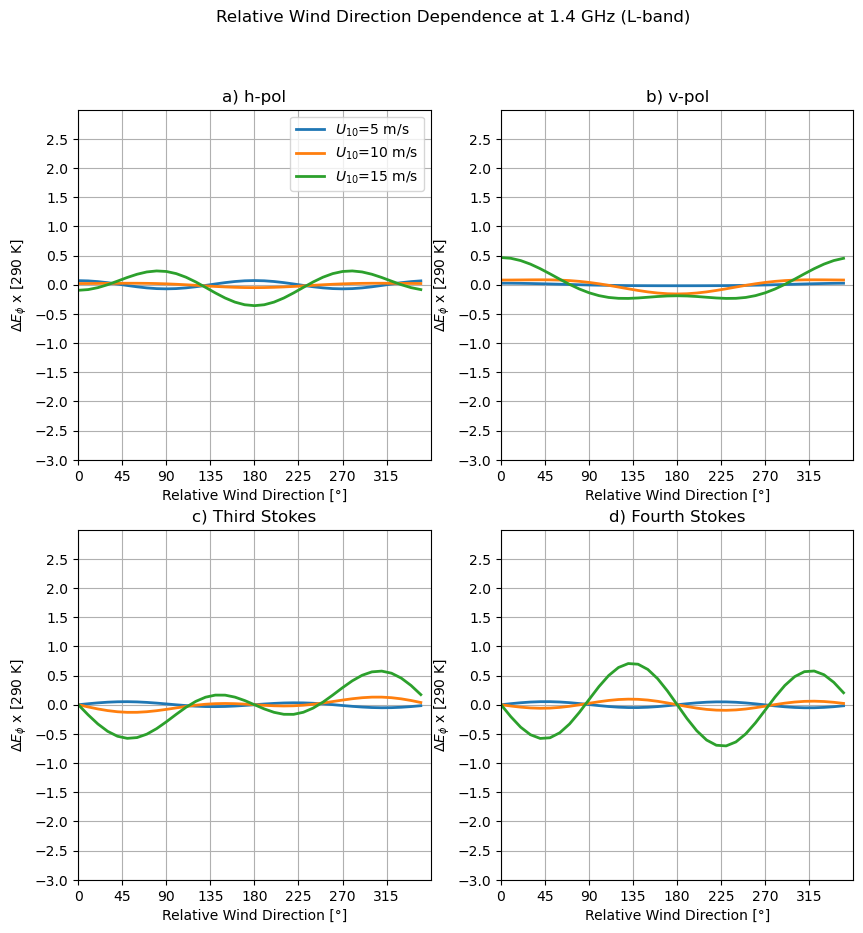

In [20]:
# Plot the relative wind direction-dependent emissivity components at L-band and all Four Stokes components

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Relative Wind Direction Dependence at 1.4 GHz (L-band)')
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_L_h[51,:], '-', linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_L_h[101,:], '-',linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_L_h[151,:], '-', linewidth=2)
ax1.grid()
ax1.set_title("a) h-pol")
ax1.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax1.axis([0, 360, -3, 3])
ax1.set_xlabel('Relative Wind Direction [°]')
ax1.set_xticks(np.arange(0, 360, 45))
ax1.set_yticks(np.arange(-3, 3, .5))
ax1.legend(['$U_{10}$=5 m/s','$U_{10}$=10 m/s','$U_{10}$=15 m/s'], loc='best')
ax2.plot(phi_r_deg, 290 * Delta_E_phi_L_v[51,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_L_v[101,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_L_v[151,:], '-', linewidth=2)
ax2.grid()
ax2.set_title("b) v-pol")
ax2.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax2.axis([0, 360, -3, 3])
ax2.set_xlabel('Relative Wind Direction [°]')
ax2.set_xticks(np.arange(0, 360, 45))
ax2.set_yticks(np.arange(-3, 3, .5))
ax3.plot(phi_r_deg, 290 * Delta_E_phi_L_3[51,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_L_3[101,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_L_3[151,:], '-', linewidth=2)
ax3.grid()
ax3.set_title("c) Third Stokes")
ax3.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax3.axis([0, 360, -3, 3])
ax3.set_xlabel('Relative Wind Direction [°]')
ax3.set_xticks(np.arange(0, 360, 45))
ax3.set_yticks(np.arange(-3, 3, .5))
ax4.plot(phi_r_deg, 290 * Delta_E_phi_L_4[51,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_L_4[101,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_L_4[151,:], '-', linewidth=2)
ax4.grid()
ax4.set_title("d) Fourth Stokes")
ax4.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax4.axis([0, 360, -3, 3])
ax4.set_yticks(np.arange(-3, 3, .5))
ax4.set_xlabel('Relative Wind Direction [°]')
ax4.set_xticks(np.arange(0, 360, 45))
ax4.tick_params(axis='x', labelsize=10)
ax4.tick_params(axis='y', labelsize=10)


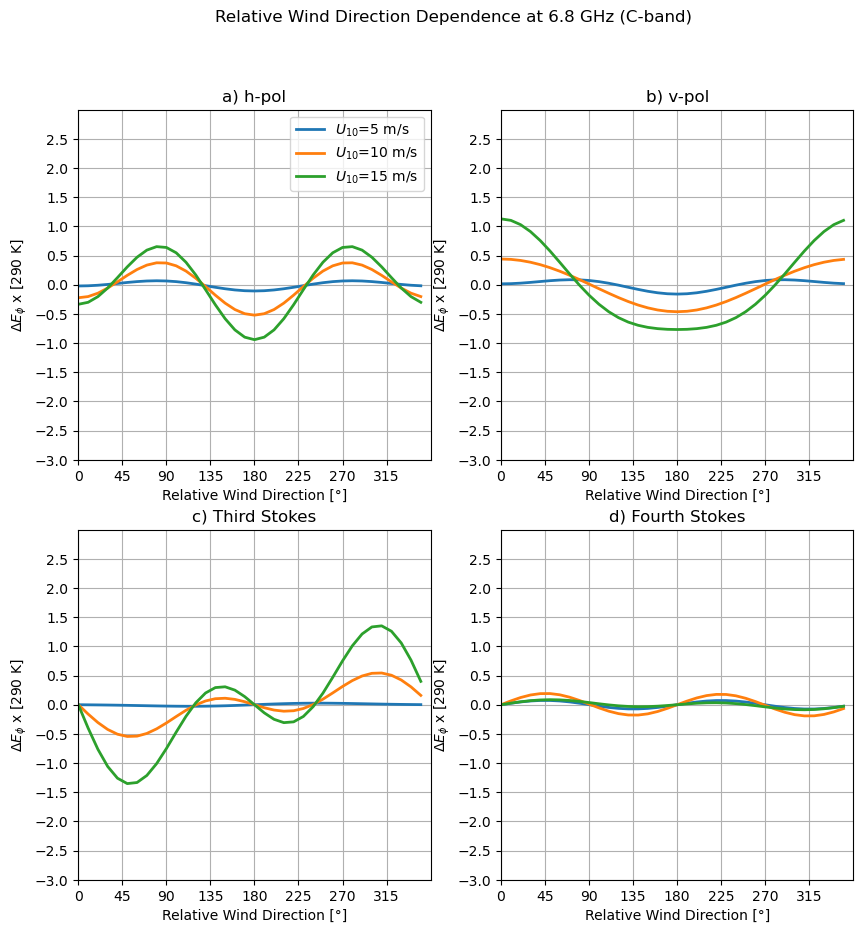

In [21]:
# Plot the relative wind direction-dependent emissivity components at C-band and all Four Stokes components

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Relative Wind Direction Dependence at 6.8 GHz (C-band)')
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_C_h[51,:], '-', linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_C_h[101,:], '-',linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_C_h[151,:], '-', linewidth=2)
ax1.grid()
ax1.set_title("a) h-pol")
ax1.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax1.axis([0, 360, -3, 3])
ax1.set_xlabel('Relative Wind Direction [°]')
ax1.set_xticks(np.arange(0, 360, 45))
ax1.set_yticks(np.arange(-3, 3, .5))
ax1.legend(['$U_{10}$=5 m/s','$U_{10}$=10 m/s','$U_{10}$=15 m/s'], loc='best')
ax2.plot(phi_r_deg, 290 * Delta_E_phi_C_v[51,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_C_v[101,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_C_v[151,:], '-', linewidth=2)
ax2.grid()
ax2.set_title("b) v-pol")
ax2.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax2.axis([0, 360, -3, 3])
ax2.set_xlabel('Relative Wind Direction [°]')
ax2.set_xticks(np.arange(0, 360, 45))
ax2.set_yticks(np.arange(-3, 3, .5))
ax3.plot(phi_r_deg, 290 * Delta_E_phi_C_3[51,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_C_3[101,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_C_3[151,:], '-', linewidth=2)
ax3.grid()
ax3.set_title("c) Third Stokes")
ax3.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax3.axis([0, 360, -3, 3])
ax3.set_xlabel('Relative Wind Direction [°]')
ax3.set_xticks(np.arange(0, 360, 45))
ax3.set_yticks(np.arange(-3, 3, .5))
ax4.plot(phi_r_deg, 290 * Delta_E_phi_C_4[51,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_C_4[101,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_C_4[151,:], '-', linewidth=2)
ax4.grid()
ax4.set_title("d) Fourth Stokes")
ax4.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax4.axis([0, 360, -3, 3])
ax4.set_yticks(np.arange(-3, 3, .5))
ax4.set_xlabel('Relative Wind Direction [°]')
ax4.set_xticks(np.arange(0, 360, 45))
ax4.tick_params(axis='x', labelsize=10)
ax4.tick_params(axis='y', labelsize=10)


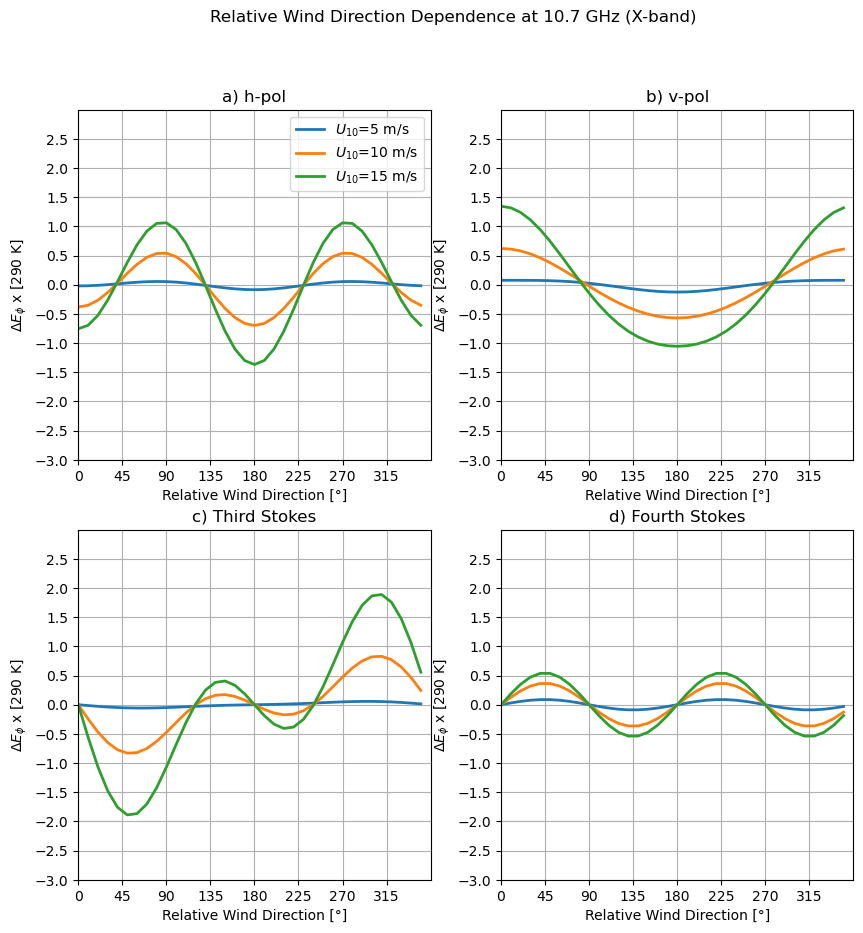

In [22]:
# Plot the relative wind direction-dependent emissivity components at X-band and all Four Stokes components

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Relative Wind Direction Dependence at 10.7 GHz (X-band)')
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_X_h[51,:], '-', linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_X_h[101,:], '-',linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_X_h[151,:], '-', linewidth=2)
ax1.grid()
ax1.set_title("a) h-pol")
ax1.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax1.axis([0, 360, -3, 3])
ax1.set_xlabel('Relative Wind Direction [°]')
ax1.set_xticks(np.arange(0, 360, 45))
ax1.set_yticks(np.arange(-3, 3, .5))
ax1.legend(['$U_{10}$=5 m/s','$U_{10}$=10 m/s','$U_{10}$=15 m/s'], loc='best')
ax2.plot(phi_r_deg, 290 * Delta_E_phi_X_v[51,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_X_v[101,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_X_v[151,:], '-', linewidth=2)
ax2.grid()
ax2.set_title("b) v-pol")
ax2.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax2.axis([0, 360, -3, 3])
ax2.set_xlabel('Relative Wind Direction [°]')
ax2.set_xticks(np.arange(0, 360, 45))
ax2.set_yticks(np.arange(-3, 3, .5))
ax3.plot(phi_r_deg, 290 * Delta_E_phi_X_3[51,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_X_3[101,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_X_3[151,:], '-', linewidth=2)
ax3.grid()
ax3.set_title("c) Third Stokes")
ax3.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax3.axis([0, 360, -3, 3])
ax3.set_xlabel('Relative Wind Direction [°]')
ax3.set_xticks(np.arange(0, 360, 45))
ax3.set_yticks(np.arange(-3, 3, .5))
ax4.plot(phi_r_deg, 290 * Delta_E_phi_X_4[51,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_X_4[101,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_X_4[151,:], '-', linewidth=2)
ax4.grid()
ax4.set_title("d) Fourth Stokes")
ax4.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax4.axis([0, 360, -3, 3])
ax4.set_yticks(np.arange(-3, 3, .5))
ax4.set_xlabel('Relative Wind Direction [°]')
ax4.set_xticks(np.arange(0, 360, 45))
ax4.tick_params(axis='x', labelsize=10)
ax4.tick_params(axis='y', labelsize=10)


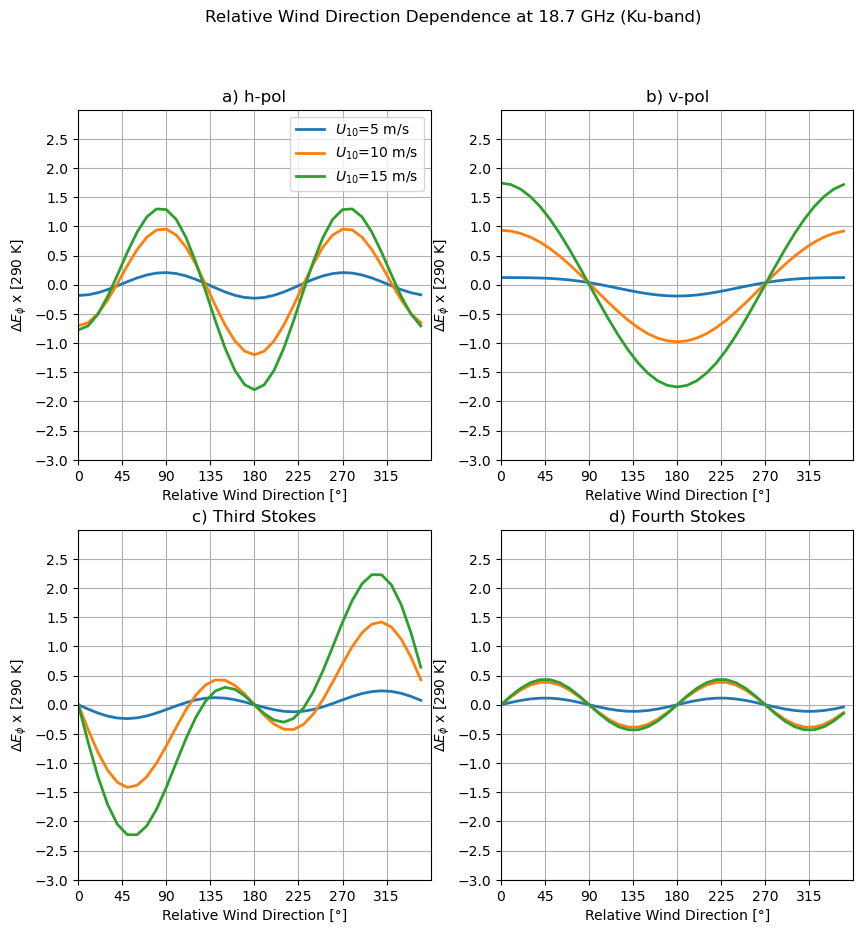

In [23]:
# Plot the relative wind direction-dependent emissivity components at Ku-band and all Four Stokes components

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Relative Wind Direction Dependence at 18.7 GHz (Ku-band)')
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_Ku_h[51,:], '-', linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_Ku_h[101,:], '-',linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_Ku_h[151,:], '-', linewidth=2)
ax1.grid()
ax1.set_title("a) h-pol")
ax1.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax1.axis([0, 360, -3, 3])
ax1.set_xlabel('Relative Wind Direction [°]')
ax1.set_xticks(np.arange(0, 360, 45))
ax1.set_yticks(np.arange(-3, 3, .5))
ax1.legend(['$U_{10}$=5 m/s','$U_{10}$=10 m/s','$U_{10}$=15 m/s'], loc='best')
ax2.plot(phi_r_deg, 290 * Delta_E_phi_Ku_v[51,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_Ku_v[101,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_Ku_v[151,:], '-', linewidth=2)
ax2.grid()
ax2.set_title("b) v-pol")
ax2.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax2.axis([0, 360, -3, 3])
ax2.set_xlabel('Relative Wind Direction [°]')
ax2.set_xticks(np.arange(0, 360, 45))
ax2.set_yticks(np.arange(-3, 3, .5))
ax3.plot(phi_r_deg, 290 * Delta_E_phi_Ku_3[51,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_Ku_3[101,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_Ku_3[151,:], '-', linewidth=2)
ax3.grid()
ax3.set_title("c) Third Stokes")
ax3.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax3.axis([0, 360, -3, 3])
ax3.set_xlabel('Relative Wind Direction [°]')
ax3.set_xticks(np.arange(0, 360, 45))
ax3.set_yticks(np.arange(-3, 3, .5))
ax4.plot(phi_r_deg, 290 * Delta_E_phi_Ku_4[51,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_Ku_4[101,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_Ku_4[151,:], '-', linewidth=2)
ax4.grid()
ax4.set_title("d) Fourth Stokes")
ax4.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax4.axis([0, 360, -3, 3])
ax4.set_yticks(np.arange(-3, 3, .5))
ax4.set_xlabel('Relative Wind Direction [°]')
ax4.set_xticks(np.arange(0, 360, 45))
ax4.tick_params(axis='x', labelsize=10)
ax4.tick_params(axis='y', labelsize=10)


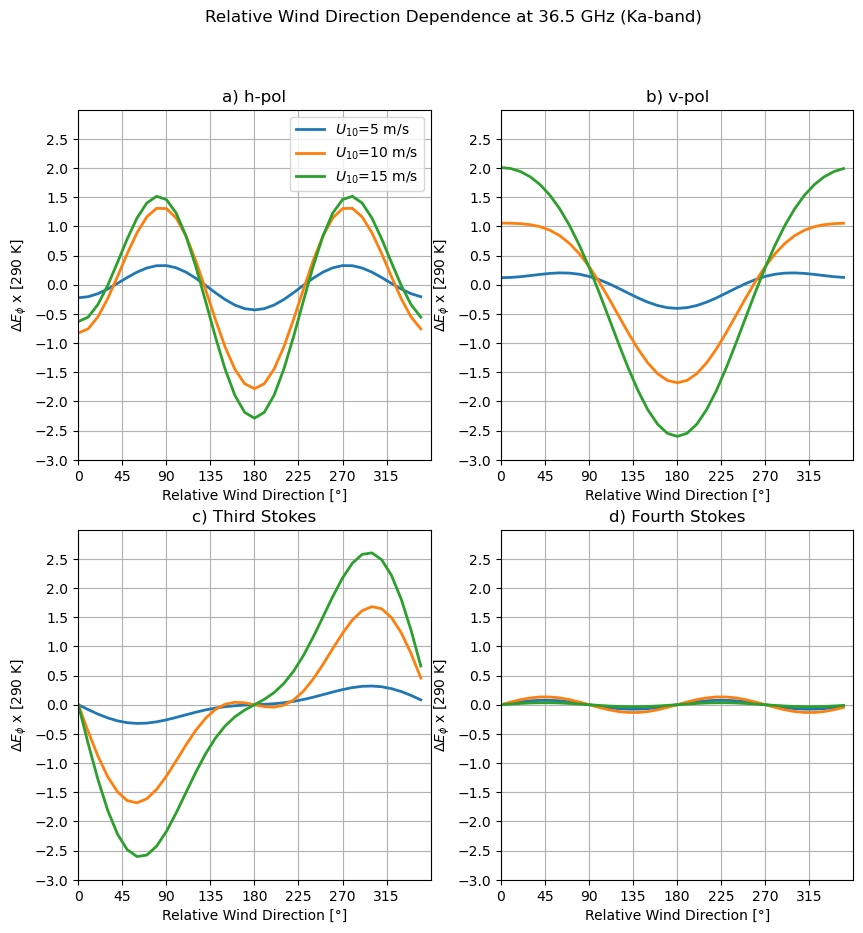

In [24]:
# Plot the relative wind direction-dependent emissivity components at Ka-band and all Four Stokes components

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig1.suptitle('Relative Wind Direction Dependence at 36.5 GHz (Ka-band)')
fig1.gca().tick_params(axis='both', which='major', labelsize=15)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_Ka_h[51,:], '-', linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_Ka_h[101,:], '-',linewidth=2)
ax1.plot(phi_r_deg, 290 * Delta_E_phi_Ka_h[151,:], '-', linewidth=2)
ax1.grid()
ax1.set_title("a) h-pol")
ax1.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax1.axis([0, 360, -3, 3])
ax1.set_xlabel('Relative Wind Direction [°]')
ax1.set_xticks(np.arange(0, 360, 45))
ax1.set_yticks(np.arange(-3, 3, .5))
ax1.legend(['$U_{10}$=5 m/s','$U_{10}$=10 m/s','$U_{10}$=15 m/s'], loc='best')
ax2.plot(phi_r_deg, 290 * Delta_E_phi_Ka_v[51,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_Ka_v[101,:], '-', linewidth=2)
ax2.plot(phi_r_deg, 290 * Delta_E_phi_Ka_v[151,:], '-', linewidth=2)
ax2.grid()
ax2.set_title("b) v-pol")
ax2.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax2.axis([0, 360, -3, 3])
ax2.set_xlabel('Relative Wind Direction [°]')
ax2.set_xticks(np.arange(0, 360, 45))
ax2.set_yticks(np.arange(-3, 3, .5))
ax3.plot(phi_r_deg, 290 * Delta_E_phi_Ka_3[51,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_Ka_3[101,:], '-', linewidth=2)
ax3.plot(phi_r_deg, 290 * Delta_E_phi_Ka_3[151,:], '-', linewidth=2)
ax3.grid()
ax3.set_title("c) Third Stokes")
ax3.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax3.axis([0, 360, -3, 3])
ax3.set_xlabel('Relative Wind Direction [°]')
ax3.set_xticks(np.arange(0, 360, 45))
ax3.set_yticks(np.arange(-3, 3, .5))
ax4.plot(phi_r_deg, 290 * Delta_E_phi_Ka_4[51,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_Ka_4[101,:], '-', linewidth=2)
ax4.plot(phi_r_deg, 290 * Delta_E_phi_Ka_4[151,:], '-', linewidth=2)
ax4.grid()
ax4.set_title("d) Fourth Stokes")
ax4.set_ylabel('$\Delta E_{\phi}$ x [290 K]')
ax4.axis([0, 360, -3, 3])
ax4.set_yticks(np.arange(-3, 3, .5))
ax4.set_xlabel('Relative Wind Direction [°]')
ax4.set_xticks(np.arange(0, 360, 45))
ax4.tick_params(axis='x', labelsize=10)
ax4.tick_params(axis='y', labelsize=10)


## Atmospheric Contributions

In what follows, we first provide codes to successively evaluate the indices of refraction owing to dry air, water vapor, cloud liquid water, cloud ice, and rain


### complex index of atmospheric refraction owing to dry air (molecular oxygen)


In [25]:
##########################################################################################
# This subfunction is part of the millimeter-wave propagation model (MPM93) software     #
# package and computes the complex index of refraction                                   #
# owing to dry air (molecular oxygen).                                                   #
#                                                                                        #
#                     ND=mpm_dry(freq, e, pd, Tr)                                        #
#                                                                                        #                                                       #
#                                                                                        #
# Outputs                                                                                #
#----------                                                                              #
# ND: index of refraction owing to dry air (molecular oxygen):                           #
#                                                                                        #
# Inputs:                                                                                #
#------------                                                                            #
# freq: Electromagnetic frequency            [GHz]                                       #
# e:    Partial pressure of the water vapour [hPa]                                       #
# pd:   Partial pressure of dry air          [hPa]                                       #
# Tr :  reciprocal temperature               [1/K]                                       #
#       Tr=300/Tp where Tp is the physical air temperature in [K]                        #
#                                                                                        #
# oxygen93.txt: numerical table of size 7 x 44 with the 7 following parameters           #
#               given for each of the 44 Oxygen lines:                                   #
#                                                                                        #
#               nu_k == oxygen[0, k]   : frequency of the k-th O2 absorption line        #
#               a1   == oxygen[1, k]   : constant for each line "k"                      #
#               a2   == oxygen[2, k]   : constant for each line "k"                      #
#               a3   == oxygen[3, k]   : constant for each line "k"                      #
#               a4   == oxygen[4, k]   : constant for each line "k"                      #
#               a5   == oxygen[5, k]   : constant for each line "k"                      #
#               a6   == oxygen[6, k]   : constant for each line "k"                      #
#                                                                                        #
#                                                                                        #                                                                                       #
#  Reference:                                                                            #
#                                                                                        #
#  H.J.Liebe, G.A.Hufford, and M.G.Cotton: Propagation Modeling OF Moist air and         #
#  Suspended Water/Ice Particles at frequencies Below 1000 GHz.  In AGARD 52nd           #
#  Specialists' Meeting of the Electromagnetic Wave Propagation Panel, Mallorca, Spain,  #
#  May 1993                                                                              #
#                                                                                        #
#           Code written by Reul.N    nicolas.reul@ifremer.fr                            #
#                                                                                        #
#                                 August 2023                                            #
# ########################################################################################

def mpm_dry(freq, e, pd, Tr):
    
    # Load Data of the oxygen lines
    oxygen93 = np.loadtxt('oxygen93.txt')
    oxygen=np.transpose(oxygen93)

    ND = []
    for f in freq:  # loop for frequency
    
        nd = 0.2588 * pd * Tr  # non-dispersive contribution

        for k in range(oxygen.shape[1]):  # loop for lines
            Sk = 1e-6 * oxygen[1, k] / oxygen[0, k] * pd * Tr**3 * np.exp(oxygen[2, k] * (1 - Tr))  # line strength with correction 1e-6
            gammak = oxygen[3, k] / 1000 * (pd * Tr**oxygen[4, k] + 1.1 * e * Tr)  # line width
            gammak = np.sqrt(gammak**2 + 2.25e-6)  # Zeeman-Effect
            deltak = 1e-3 * (oxygen[5, k] + oxygen[6, k] * Tr) * (pd + e) * Tr**0.8  # Overlap parameter with correction 1e-3
            Fk = f * ((1 - 1j * deltak) / (oxygen[0, k] - f - 1j * gammak) - (1 + 1j * deltak) / (oxygen[0, k] + f + 1j * gammak))  # lines form function
            nd = nd + Sk * Fk

        # non-resonant contribution
        So = 6.14e-5 * pd * Tr**2
        Fo = -f / (f + 1j * 0.56e-3 * (pd + e) * Tr**0.8)
        Sn = 1.4e-12 * pd**2 * Tr**3.5
        Fn = f / (1 + 1.93e-5 * f**1.5)  # correction 1.9 -> 1.93
        nd = nd + So * Fo + 1j * Sn * Fn
        ND.append(nd)

    return ND


### Complex index of atmospheric refraction owing to water vapor

In [26]:
##########################################################################################
# This subfunction is part of the MPM93 software package and computes                    #
# the complex index of refraction for water vapor. The index of refraction for water     #
# vapor is the sum of a nondispersive term, a continuum term, and a sum over 35          #
# resonant absorption lines (including one pseudo-line at 1780 GHz).                     #
# At the CIMR frequencies the continuum term is negligible.                              #
#                                                                                        #
#                     NV= mpm_vapor(freq, e, pd, Tr)                                     #
#                                                                                        #                                                     #
#                                                                                        #
# Outputs                                                                                #
#----------                                                                              #
# NV: index of refraction owing to water vapor:                                          #
#                                                                                        #
# Inputs:                                                                                #
#------------                                                                            #
# freq: Electromagnetic frequency            [GHz]                                       #
# e:    Partial pressure of the water vapour [hPa]                                       #
# pd:   Partial pressure of dry air          [hPa]                                       #
# Tr :  reciprocal temperature               [1/K]                                       #
#       Tr=300/Tp where Tp is the physical air temperature in [K]                        #
#                                                                                        #  
# water93.txt: numerical table of size 7 x 35 with the 7 following parameters            #
#               given for each of the 35 water vapor lines:                              #
#                                                                                        #  
#               nu_k == water[0, k]   : frequency of the k-th vapor absorption line      #
#               b1   == water[1, k]   : constant for each line "k"                       #
#               b2   == water[2, k]   : constant for each line "k"                       #
#               b3   == water[3, k]   : constant for each line "k"                       #
#               b4   == water[4, k]   : constant for each line "k"                       #
#               b5   == water[5, k]   : constant for each line "k"                       #
#               b6   == water[6, k]   : constant for each line "k"                       #
#                                                                                        #
#                                                                                        #                                                                                       #
#  Code written by Reul. N. @Ifremer, May 2023                                           #
#                                                                                        #
#  Reference:                                                                            #
#                                                                                        #
#  H.J.Liebe, G.A.Hufford, and M.G.Cotton: Propagation Modeling OF Moist air and         #
#  Suspended Water/Ice Particles at frequencies Below 1000 GHz.  In AGARD 52nd           #
#  Specialists' Meeting of the Electromagnetic Wave Propagation Panel, Mallorca, Spain,  #
#  May 1993                                                                              #
#                                                                                        #
# ########################################################################################


def mpm_vapor(freq, e, pd, Tr):
    
    # Load data for water vapor lines
    water93 = np.loadtxt('water93.txt')
    water   = np.transpose(water93)

    NV = []
    for f in freq:  # loop over frequency
        nv = (4.163 * Tr + 0.239) * e * Tr  # non-dispersive contribution

        for k in range(water.shape[1]):  # loop over lines
            S = water[1, k] / water[0, k] * e * Tr**3.5 * np.exp(water[2, k] * (1 - Tr))  # line strength
            gammak = water[3, k] / 1000 * (water[4, k] * e * Tr**water[6, k] + pd * Tr**water[5, k])  # Line width
            dopp = np.where(pd + e < 0.7)[0]  # Doppler broadening
            if len(dopp) > 0:
                gammak[dopp] = 0.535 * gammak[dopp] + np.sqrt(0.217 * gammak[dopp]**2 + (1.46e-6 * gammak[dopp] * np.sqrt(Tr[dopp]))**2)
            F = f * (1 / (water[0, k] - f - 1j * gammak) - 1 / (water[0, k] + f + 1j * gammak))  # lines form function
            nv = nv + S * F

        NV.append(nv)

    return NV


### Complex index of atmospheric refraction due to cloud liquid water

In [27]:
##########################################################################################
# This subfunction is part of the MPM93 software package and computes                    #
# the complex index of refraction for cloud liquid water.                                #
#                                                                                        #
#                     NW=mpm_water(freq, Tr, rho_clw)                                    #
#                                                                                        #                                                      #
#                                                                                        #
# Outputs                                                                                #
#----------                                                                              #
# NW: complex index of refraction owing to cloud liquid water [ppm]                      #
#                                                                                        #
# Inputs:                                                                                #
#------------                                                                            #
# freq:    Electromagnetic frequency            [GHz]                                    #
# rho_clw: Cloud Water droplet density          [g/m^3]                                  #
# Tr :     reciprocal temperature               [1/K]                                    #
#          Tr=300/Tp where Tp is the physical air temperature in [K]                     #                                                                                     #
#                                                                                        #                                                                                       #
#  Code written by Reul. N. @Ifremer, May 2023                                           #
#                                                                                        #
#  Reference:                                                                            #
#                                                                                        #                  
#  H.J.Liebe, G.A.Hufford, and M.G.Cotton: Propagation Modeling OF Moist air and         #
#  Suspended Water/Ice Particles at frequencies Below 1000 GHz.  In AGARD 52nd           #
#  Specialists' Meeting of the Electromagnetic Wave Propagation Panel, Mallorca, Spain,  #
#  May 1993                                                                              #
#                                                                                        #
# ########################################################################################


def mpm_water(freq, Tr, rho_clw):

    # static and high-frequency permittivities
    eo = 77.66 + 103.3 * (Tr - 1)
    e1 = 0.0671 * eo
    e2 = 3.52 - 7.52 * (Tr - 1)  

    # relaxation frequencies expressed in gigahertz;

    gamma1 = 20.2 - 146.4 * (Tr - 1) + 316 * (Tr - 1) ** 2  
    gamma2 = 39.8 * gamma1

    NW = []

    for f in freq:
        ew = eo - f * ((eo - e1) / (f + 1j * gamma1) + (e1 - e2) / (f + 1j * gamma2))
        NW.append(1.5 * (rho_clw) * (ew - 1) / (ew + 2))

    return NW


### Complex index of atmospheric refraction for cloud ice water

In [28]:
##########################################################################################
# This subfunction is part of the MPM93 software package and computes                    #
# the complex index of refraction for cloud ice water.                                   #
#                                                                                        #
#                         NI=mpm_ice(freq, Tr, rho_ice)                                 #
#                                                                                        #                                                     #
#                                                                                        #
# Outputs                                                                                #
#----------                                                                              #
# NI: complex index of refraction owing to cloud ice water [ppm]                         #
#                                                                                        #
# Inputs:                                                                                #
#------------                                                                            #
# freq:    Electromagnetic frequency            [GHz]                                    #
# rho_ice: Cloud ice Water density              [g/m^3]                                  #
# Tr :     reciprocal temperature               [1/K]                                    #
#          Tr=300/Tp where Tp is the physical air temperature in [K]                     #                                                                                     #
#                                                                                        #                                                                                       #
#  Code written by Reul. N. @Ifremer, May 2023                                           #
#                                                                                        #
#  Reference:                                                                            #
#                                                                                        #                  
#  H.J.Liebe, G.A.Hufford, and M.G.Cotton: Propagation Modeling OF Moist air and         #
#  Suspended Water/Ice Particles at frequencies Below 1000 GHz.  In AGARD 52nd           #
#  Specialists' Meeting of the Electromagnetic Wave Propagation Panel, Mallorca, Spain,  #
#  May 1993                                                                              #
#                                                                                        #
# ########################################################################################

def mpm_ice(freq, Tr, rho_ice):
    
    ai = (Tr - 0.171) * np.exp(17.0 - 22.1 * Tr)
    bi = ((0.233 / (1 - 0.993 / Tr)) ** 2 + 6.33 / Tr - 1.31) * 1e-5

    NI = []

    for f in freq:
            ei = 3.15 + 1j * (ai / f + bi * f)
            NI.append(1.5 * (rho_ice/0.916) * ((ei - 1) / (ei + 2)))

    return NI


### Complex index of atmospheric refraction owing to rain

In [29]:
##########################################################################################
# This subfunction is part of the MPM93 software package and computes                    #
# the complex index of refraction because of rain.                                       #
#                                                                                        #
#                       NR=mpm_rain(freq, R)                                             #
#                                                                                        #                                                      #
#                                                                                        #
# Outputs                                                                                #
#----------                                                                              #
# NR: index of refraction owing to rain:                                                 #
#                                                                                        #
# Inputs:                                                                                #
#------------                                                                            #
# freq: Electromagnetic frequency            [GHz]                                       #
# R   : Rain rate                            [mm/h]                                      #
#                                                                                        #
#                                                                                        #                                                                                       #
#  Code written by Reul. N. @Ifremer, May 2023                                           #
#                                                                                        #
#  Reference:                                                                            #
#                                                                                        #
#  H.J.Liebe, G.A.Hufford, and M.G.Cotton: Propagation Modeling OF Moist air and         #
#  Suspended Water/Ice Particles at frequencies Below 1000 GHz.  In AGARD 52nd           #
#  Specialists' Meeting of the Electromagnetic Wave Propagation Panel, Mallorca, Spain,  #
#  May 1993                                                                              #
#                                                                                        #
# ########################################################################################



def mpm_rain(freq, R):
    NR = []

    for f in freq:
        x1, y1, x2, y2 = 0, 0, 0, 0

        if 1 <= f <= 2.9:
            x1 = 3.51e-4
            y1 = 1.03
        elif 2.9 < f <= 54:
            x1 = 2.31e-4
            y1 = 1.42
        elif 54 < f <= 180:
            x1 = 0.225
            y1 = -0.301
        elif 180 < f <= 1000:
            x1 = 18.6
            y1 = -1.151

        if 1 <= f <= 8.5:
            x2 = 0.851
            y2 = 0.158
        elif 8.5 < f <= 25:
            x2 = 1.41
            y2 = -0.0779
        elif 25 < f <= 164:
            x2 = 2.63
            y2 = -0.272
        elif 164 < f <= 1000:
            x2 = 0.616
            y2 = 0.0126

        fr = 53 - R * (0.37 - 0.0015 * R)
        y = f / fr
        cr = x1 * f**y1
        z = x2 * f**y2

        NR.append((R * (0.012 * R - 3.7) * y**2.5) / (fr * (1 + y**2.5)) + 1j * cr * R**z)

    return NR


### Atmospheric contributions to TOA Brightness Temperatures

Here, we evaluate the upwelling and downwelling brightness temperature for vertical atmospheric profiles from the standard 1976 US atmosphere


#### standard 1976 atmosphere profiles


In [30]:
#################################################################################
# load standard 1976 atmosphere used for illustration
##################################################################################

Stand_atm=np.loadtxt('Standard_1976_atmo.txt')

# Extract the columns
Z = Stand_atm[:,0]       # Total Reporting Altitudes [0<=alt<=1000 km] [km]
T = Stand_atm[:, 1]       # Temperature array [0<=alt<=1000 km] [K]
P = Stand_atm[:, 2]       # Pressure array [0<=alt<=1000 km] [Pa]
rho = Stand_atm[:, 3]     # Density array [0<=alt<=1000 km] [kg/m^3]
print(np.size(T))

# Convert pressure to hPa
P = 0.01 * P

# Compute the reciprocal temperature in [1/K].
Tr = 300.0 / T

# Compute saturation vapor pressure in [hPa].
esat = 2.408e11 * Tr**5.0 * np.exp(-22.644 * Tr)

# Partial pressure of the water vapor
# We assume a constant 50% relative humidity versus altitude
rh = 50 * np.ones(len(Z))  # rh is relative humidity
e = esat * rh / 100

# Partial pressure of dry air
pd = P - e

# Compute dry air density in [kg/m^3].
# Recall pd is dry air pressure in [hPa].
Rd = 287.0
rho = pd * 100 / (Rd * Tr)

# The cloud liquid water is assumed to be concentrated at a single altitude,
# and to have the temperature of the air at that altitude
# cloud liquid water density (usually called Liquid Water Content LWC)
clw = np.zeros(len(Z))
clw[10] = 1e-4  # m

# Compute density of cloud water in [kg/m^3].
# clw is assumed to be cloud water mixing ratio, which is
# defined as (mass of water) / (mass of dry air), and it has units of [kg/kg].
rho_water = rho * clw

# Separate into liquid and ice.
rho_ice = rho_water.copy()
ind = np.where(T < 273.15)[0]
rho_water[ind] = 0.0
ind = np.where(T >= 273.15)[0]
rho_ice[ind] = 0.0

# Plot T, P, rho as a function of Z for the 1976 U.S. Standard Atmosphere
plt.figure(1, figsize=(15, 5))

plt.subplot(131)
plt.plot(T, Z, '-', linewidth=2)
plt.xlabel('Atmospheric Temperature $T_p$ [K]', fontsize=18)
plt.ylabel('Height above Sea Level [km]', fontsize=18)
plt.grid(True)
plt.tick_params(labelsize=15)

plt.subplot(132)
plt.plot(P, Z, '-', linewidth=2)
plt.xlabel('Atmospheric Pressure [hPa]', fontsize=18)
plt.ylabel('Height above Sea Level [km]', fontsize=18)
plt.grid(True)
plt.tick_params(labelsize=15)

plt.subplot(133)
plt.plot(rho, Z, '-', linewidth=2)
plt.xlabel('Atmospheric Density [$kg/m^3$]', fontsize=18)
plt.ylabel('Height above Sea Level [km]', fontsize=18)
plt.grid(True)
plt.tick_params(labelsize=15)

plt.suptitle('1976 U.S. Standard Atmosphere', fontsize=25)
plt.tight_layout()
plt.show()


FileNotFoundError: Standard_1976_atmo.txt not found.

#### Evaluation at each vertical level and integration

In [224]:
# L-band indices of refractions

freqL = [1.4]

ND_L = mpm_dry(freqL, e, pd, Tr)
NV_L = mpm_vapor(freqL, e, pd, Tr)
NW_L = mpm_water(freqL, Tr, rho_water / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].
NI_L = mpm_ice(freqL, Tr, rho_ice / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].

# dB to nepers conversion factor.
db_to_nepers = np.log(10) / 10.0

# Convert index of refraction to power attenuation/distance (specific attenuation) in units of [nepers/m].
# Note that the MPM computes specific attenuation in units of [nepers/km], not [nepers/m].
# These attenuation coefficients apply to power not amplitude. Divide by two to get amplitude coefficients.
dry_alpha_L = db_to_nepers * 0.1820 * np.array(freqL) * np.imag(ND_L) / 1000
vapor_alpha_L = db_to_nepers * 0.1820 * np.array(freqL) * np.imag(NV_L) / 1000
water_alpha_L = db_to_nepers * 0.1820 * np.array(freqL) * np.imag(NW_L) / 1000
ice_alpha_L = db_to_nepers * 0.1820 * np.array(freqL) * np.imag(NI_L) / 1000

# C-band indices of refractions

freqC = [6.9]

ND_C = mpm_dry(freqC, e, pd, Tr)
NV_C = mpm_vapor(freqC, e, pd, Tr)
NW_C = mpm_water(freqC, Tr, rho_water / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].
NI_C = mpm_ice(freqC, Tr, rho_ice / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].

# Convert index of refraction to power attenuation/distance (specific attenuation) in units of [nepers/m].
# Note that the MPM computes specific attenuation in units of [nepers/km], not [nepers/m].
# These attenuation coefficients apply to power not amplitude. Divide by two to get amplitude coefficients.
dry_alpha_C = db_to_nepers * 0.1820 * np.array(freqC) * np.imag(ND_C) / 1000
vapor_alpha_C = db_to_nepers * 0.1820 * np.array(freqC) * np.imag(NV_C) / 1000
water_alpha_C = db_to_nepers * 0.1820 * np.array(freqC) * np.imag(NW_C) / 1000
ice_alpha_C = db_to_nepers * 0.1820 * np.array(freqC) * np.imag(NI_C) / 1000

# X-band indices of refractions

freqX = [10.7]

ND_X = mpm_dry(freqX, e, pd, Tr)
NV_X = mpm_vapor(freqX, e, pd, Tr)
NW_X = mpm_water(freqX, Tr, rho_water / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].
NI_X = mpm_ice(freqX, Tr, rho_ice / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].

# Convert index of refraction to power attenuation/distance (specific attenuation) in units of [nepers/m].
# Note that the MPM computes specific attenuation in units of [nepers/km], not [nepers/m].
# These attenuation coefficients apply to power not amplitude. Divide by two to get amplitude coefficients.
dry_alpha_X = db_to_nepers * 0.1820 * np.array(freqX) * np.imag(ND_X) / 1000
vapor_alpha_X = db_to_nepers * 0.1820 * np.array(freqX) * np.imag(NV_X) / 1000
water_alpha_X = db_to_nepers * 0.1820 * np.array(freqX) * np.imag(NW_X) / 1000
ice_alpha_X = db_to_nepers * 0.1820 * np.array(freqX) * np.imag(NI_X) / 1000

# Ku-band indices of refractions

freqKu = [18.7]

ND_Ku = mpm_dry(freqKu, e, pd, Tr)
NV_Ku = mpm_vapor(freqKu, e, pd, Tr)
NW_Ku = mpm_water(freqKu, Tr, rho_water / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].
NI_Ku = mpm_ice(freqKu, Tr, rho_ice / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].

# Convert index of refraction to power attenuation/distance (specific attenuation) in units of [nepers/m].
# Note that the MPM computes specific attenuation in units of [nepers/km], not [nepers/m].
# These attenuation coefficients apply to power not amplitude. Divide by two to get amplitude coefficients.
dry_alpha_Ku = db_to_nepers * 0.1820 * np.array(freqKu) * np.imag(ND_Ku) / 1000
vapor_alpha_Ku = db_to_nepers * 0.1820 * np.array(freqKu) * np.imag(NV_Ku) / 1000
water_alpha_Ku = db_to_nepers * 0.1820 * np.array(freqKu) * np.imag(NW_Ku) / 1000
ice_alpha_Ku = db_to_nepers * 0.1820 * np.array(freqKu) * np.imag(NI_Ku) / 1000

# Ka-band indices of refractions

freqKa = [36.5]

ND_Ka = mpm_dry(freqKa, e, pd, Tr)
NV_Ka = mpm_vapor(freqKa, e, pd, Tr)
NW_Ka = mpm_water(freqKa, Tr, rho_water / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].
NI_Ka = mpm_ice(freqKa, Tr, rho_ice / 10000)  # Here we must pass liquid water density in units of [gm/cm^3].

# Convert index of refraction to power attenuation/distance (specific attenuation) in units of [nepers/m].
# Note that the MPM computes specific attenuation in units of [nepers/km], not [nepers/m].
# These attenuation coefficients apply to power not amplitude. Divide by two to get amplitude coefficients.
dry_alpha_Ka = db_to_nepers * 0.1820 * np.array(freqKa) * np.imag(ND_Ka) / 1000
vapor_alpha_Ka = db_to_nepers * 0.1820 * np.array(freqKa) * np.imag(NV_Ka) / 1000
water_alpha_Ka = db_to_nepers * 0.1820 * np.array(freqKa) * np.imag(NW_Ka) / 1000
ice_alpha_Ka = db_to_nepers * 0.1820 * np.array(freqKa) * np.imag(NI_Ka) / 1000
from scipy import integrate

# CIMR beams central incidence angle at each frequency (L,C,X,Ku,Ka)

EIA = [51.95, 55.2, 55.2, 55.2, 55.2]

Z = Stand_atm[:,0]       # Total Reporting Altitudes [0<=alt<=1000 km] [km]
Z = Z * 1e3  # height in meters

#######################################################################################
# Compute integrated absorption from the surface to each level.
#######################################################################################

# L-band
att_dry_up_L = integrate.cumtrapz(dry_alpha_L * 1/np.cos(np.radians(EIA[0])), Z, initial=0)
att_vapor_up_L = integrate.cumtrapz(vapor_alpha_L * 1/np.cos(np.radians(EIA[0])), Z, initial=0)
att_water_up_L = integrate.cumtrapz(water_alpha_L * 1/np.cos(np.radians(EIA[0])), Z, initial=0)
att_ice_up_L = integrate.cumtrapz(ice_alpha_L * 1/np.cos(np.radians(EIA[0])), Z, initial=0)
att_tot_up_L = att_dry_up_L + att_vapor_up_L + att_water_up_L + att_ice_up_L

# C-band
att_dry_up_C = integrate.cumtrapz(dry_alpha_C * 1/np.cos(np.radians(EIA[1])), Z, initial=0)
att_vapor_up_C = integrate.cumtrapz(vapor_alpha_C * 1/np.cos(np.radians(EIA[1])), Z, initial=0)
att_water_up_C = integrate.cumtrapz(water_alpha_C * 1/np.cos(np.radians(EIA[1])), Z, initial=0)
att_ice_up_C = integrate.cumtrapz(ice_alpha_C * 1/np.cos(np.radians(EIA[1])), Z, initial=0)
att_tot_up_C = att_dry_up_C + att_vapor_up_C + att_water_up_C + att_ice_up_C

# X-band
att_dry_up_X = integrate.cumtrapz(dry_alpha_X * 1/np.cos(np.radians(EIA[2])), Z, initial=0)
att_vapor_up_X = integrate.cumtrapz(vapor_alpha_X * 1/np.cos(np.radians(EIA[2])), Z, initial=0)
att_water_up_X = integrate.cumtrapz(water_alpha_X * 1/np.cos(np.radians(EIA[2])), Z, initial=0)
att_ice_up_X = integrate.cumtrapz(ice_alpha_X * 1/np.cos(np.radians(EIA[2])), Z, initial=0)
att_tot_up_X = att_dry_up_X + att_vapor_up_X + att_water_up_X + att_ice_up_X

# Ku-band
att_dry_up_Ku = integrate.cumtrapz(dry_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z, initial=0)
att_vapor_up_Ku= integrate.cumtrapz(vapor_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z, initial=0)
att_water_up_Ku = integrate.cumtrapz(water_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z, initial=0)
att_ice_up_Ku = integrate.cumtrapz(ice_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z, initial=0)
att_tot_up_Ku = att_dry_up_Ku + att_vapor_up_Ku + att_water_up_Ku + att_ice_up_Ku

# Ka-band
att_dry_up_Ka = integrate.cumtrapz(dry_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z, initial=0)
att_vapor_up_Ka= integrate.cumtrapz(vapor_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z, initial=0)
att_water_up_Ka = integrate.cumtrapz(water_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z, initial=0)
att_ice_up_Ka = integrate.cumtrapz(ice_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z, initial=0)
att_tot_up_Ka = att_dry_up_Ku + att_vapor_up_Ka + att_water_up_Ka + att_ice_up_Ka


#######################################################################################
# Compute integrated absorption from the top down to each level.
#######################################################################################

# L-band
tatt_dry_down_L   = -integrate.cumtrapz(dry_alpha_L * 1/np.cos(np.radians(EIA[0])), Z[::-1]);
tatt_vapor_down_L = -integrate.cumtrapz(vapor_alpha_L * 1/np.cos(np.radians(EIA[0])), Z[::-1]);
tatt_water_down_L = -integrate.cumtrapz(water_alpha_L * 1/np.cos(np.radians(EIA[0])), Z[::-1]);
tatt_ice_down_L   = -integrate.cumtrapz(ice_alpha_L * 1/np.cos(np.radians(EIA[0])), Z[::-1]);
att_dry_down_L   = tatt_dry_down_L[::-1];
att_vapor_down_L = tatt_vapor_down_L[::-1];
att_water_down_L = tatt_water_down_L[::-1];
att_ice_down_L   = tatt_ice_down_L[::-1];
att_tot_down_L   = att_dry_down_L + att_vapor_down_L + att_water_down_L + att_ice_down_L;

# C-band

tatt_dry_down_C   = -integrate.cumtrapz(dry_alpha_C * 1/np.cos(np.radians(EIA[1])), Z[::-1]);
tatt_vapor_down_C = -integrate.cumtrapz(vapor_alpha_C * 1/np.cos(np.radians(EIA[1])), Z[::-1]);
tatt_water_down_C = -integrate.cumtrapz(water_alpha_C * 1/np.cos(np.radians(EIA[1])), Z[::-1]);
tatt_ice_down_C   = -integrate.cumtrapz(ice_alpha_C * 1/np.cos(np.radians(EIA[1])), Z[::-1]);
att_dry_down_C   = tatt_dry_down_C[::-1];
att_vapor_down_C = tatt_vapor_down_C[::-1];
att_water_down_C = tatt_water_down_C[::-1];
att_ice_down_C   = tatt_ice_down_C[::-1];
att_tot_down_C   = att_dry_down_C + att_vapor_down_C + att_water_down_C + att_ice_down_C;

# X-band

tatt_dry_down_X   = -integrate.cumtrapz(dry_alpha_X * 1/np.cos(np.radians(EIA[2])), Z[::-1]);
tatt_vapor_down_X = -integrate.cumtrapz(vapor_alpha_X * 1/np.cos(np.radians(EIA[2])), Z[::-1]);
tatt_water_down_X = -integrate.cumtrapz(water_alpha_X * 1/np.cos(np.radians(EIA[2])), Z[::-1]);
tatt_ice_down_X   = -integrate.cumtrapz(ice_alpha_X * 1/np.cos(np.radians(EIA[2])), Z[::-1]);
att_dry_down_X   = tatt_dry_down_X[::-1];
att_vapor_down_X = tatt_vapor_down_X[::-1];
att_water_down_X = tatt_water_down_X[::-1];
att_ice_down_X   = tatt_ice_down_X[::-1];
att_tot_down_X   = att_dry_down_X + att_vapor_down_X + att_water_down_X + att_ice_down_X;

# Ku-band

tatt_dry_down_Ku   = -integrate.cumtrapz(dry_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z[::-1]);
tatt_vapor_down_Ku = -integrate.cumtrapz(vapor_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z[::-1]);
tatt_water_down_Ku = -integrate.cumtrapz(water_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z[::-1]);
tatt_ice_down_Ku   = -integrate.cumtrapz(ice_alpha_Ku * 1/np.cos(np.radians(EIA[3])), Z[::-1]);
att_dry_down_Ku   = tatt_dry_down_Ku[::-1];
att_vapor_down_Ku = tatt_vapor_down_Ku[::-1];
att_water_down_Ku = tatt_water_down_Ku[::-1];
att_ice_down_Ku   = tatt_ice_down_Ku[::-1];
att_tot_down_Ku   = att_dry_down_Ku + att_vapor_down_Ku + att_water_down_Ku + att_ice_down_Ku;

# Ka-band

tatt_dry_down_Ka   = -integrate.cumtrapz(dry_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z[::-1]);
tatt_vapor_down_Ka = -integrate.cumtrapz(vapor_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z[::-1]);
tatt_water_down_Ka = -integrate.cumtrapz(water_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z[::-1]);
tatt_ice_down_Ka   = -integrate.cumtrapz(ice_alpha_Ka * 1/np.cos(np.radians(EIA[4])), Z[::-1]);
att_dry_down_Ka   = tatt_dry_down_Ka[::-1];
att_vapor_down_Ka = tatt_vapor_down_Ka[::-1];
att_water_down_Ka = tatt_water_down_Ka[::-1];
att_ice_down_Ka   = tatt_ice_down_Ka[::-1];
att_tot_down_Ka   = att_dry_down_Ka + att_vapor_down_Ka + att_water_down_Ka + att_ice_down_Ka;

#######################################################################################
# Compute transmission from each level to the bottom of the atmosphere at zenith.
# This is also the transmission from the bottom to each level in the atmosphere.
########################################################################################

# L-band
trans_dry_up_L     = np.exp(-att_dry_up_L);
trans_vapor_up_L   = np.exp(-att_vapor_up_L);
trans_water_up_L   = np.exp(-att_water_up_L);
trans_ice_up_L     = np.exp(-att_ice_up_L);
trans_total_up_L   = trans_dry_up_L * trans_vapor_up_L * trans_water_up_L * trans_ice_up_L

# C-band
trans_dry_up_C     = np.exp(-att_dry_up_C);
trans_vapor_up_C   = np.exp(-att_vapor_up_C);
trans_water_up_C   = np.exp(-att_water_up_C);
trans_ice_up_C     = np.exp(-att_ice_up_C);
trans_total_up_C   = trans_dry_up_C * trans_vapor_up_C * trans_water_up_C * trans_ice_up_C

# X-band
trans_dry_up_X     = np.exp(-att_dry_up_X);
trans_vapor_up_X   = np.exp(-att_vapor_up_X);
trans_water_up_X   = np.exp(-att_water_up_X);
trans_ice_up_X     = np.exp(-att_ice_up_X);
trans_total_up_X   = trans_dry_up_X * trans_vapor_up_X * trans_water_up_X * trans_ice_up_X

# Ku-band
trans_dry_up_Ku     = np.exp(-att_dry_up_Ku);
trans_vapor_up_Ku   = np.exp(-att_vapor_up_Ku);
trans_water_up_Ku   = np.exp(-att_water_up_Ku);
trans_ice_up_Ku     = np.exp(-att_ice_up_Ku);
trans_total_up_Ku   = trans_dry_up_Ku * trans_vapor_up_Ku * trans_water_up_Ku * trans_ice_up_Ku

# Ka-band
trans_dry_up_Ka     = np.exp(-att_dry_up_Ka);
trans_vapor_up_Ka   = np.exp(-att_vapor_up_Ka);
trans_water_up_Ka   = np.exp(-att_water_up_Ka);
trans_ice_up_Ka     = np.exp(-att_ice_up_Ka);
trans_total_up_Ka   = trans_dry_up_Ka * trans_vapor_up_Ka * trans_water_up_Ka * trans_ice_up_Ka


########################################################################################
# Compute transmission from each level to the top of the atmosphere at zenith.
########################################################################################

# L-band
trans_dry_down_L   = np.exp(-att_dry_down_L);
trans_vapor_down_L = np.exp(-att_vapor_down_L);
trans_water_down_L = np.exp(-att_water_down_L);
trans_ice_down_L   = np.exp(-att_ice_down_L);
trans_total_down_L = trans_dry_down_L * trans_vapor_down_L * trans_water_down_L * trans_ice_down_L


# C-band
trans_dry_down_C   = np.exp(-att_dry_down_C);
trans_vapor_down_C = np.exp(-att_vapor_down_C);
trans_water_down_C = np.exp(-att_water_down_C);
trans_ice_down_C   = np.exp(-att_ice_down_C);
trans_total_down_C = trans_dry_down_C * trans_vapor_down_C * trans_water_down_C * trans_ice_down_C

# X-band
trans_dry_down_X   = np.exp(-att_dry_down_X);
trans_vapor_down_X = np.exp(-att_vapor_down_X);
trans_water_down_X = np.exp(-att_water_down_X);
trans_ice_down_X   = np.exp(-att_ice_down_X);
trans_total_down_X = trans_dry_down_X * trans_vapor_down_X * trans_water_down_X * trans_ice_down_X

# Ku-band
trans_dry_down_Ku   = np.exp(-att_dry_down_Ku);
trans_vapor_down_Ku = np.exp(-att_vapor_down_Ku);
trans_water_down_Ku = np.exp(-att_water_down_Ku);
trans_ice_down_Ku   = np.exp(-att_ice_down_Ku);
trans_total_down_Ku = trans_dry_down_Ku * trans_vapor_down_Ku * trans_water_down_Ku * trans_ice_down_Ku

# Ka-band
trans_dry_down_Ka   = np.exp(-att_dry_down_Ka);
trans_vapor_down_Ka = np.exp(-att_vapor_down_Ka);
trans_water_down_Ka = np.exp(-att_water_down_Ka);
trans_ice_down_Ka   = np.exp(-att_ice_down_Ka);
trans_total_down_Ka = trans_dry_down_Ka * trans_vapor_down_Ka * trans_water_down_Ka * trans_ice_down_Ka

#######################################################################################
# Compute unpolarized brightness temperature at each level. These variables may be viewed
# as incremental brightnesses which are then attenuated by intervening atmosphere.
########################################################################################


ltb_dry_L     =  T * dry_alpha_L;
ltb_vapor_L   =  T * vapor_alpha_L;
ltb_water_L   =  T * water_alpha_L;
ltb_ice_L     =  T * ice_alpha_L;
ltb_L         =  ltb_dry_L + ltb_vapor_L + ltb_water_L + ltb_ice_L;

ltb_dry_C     =  T * dry_alpha_C;
ltb_vapor_C   =  T * vapor_alpha_C;
ltb_water_C   =  T * water_alpha_C;
ltb_ice_C     =  T * ice_alpha_C;
ltb_C         =  ltb_dry_C + ltb_vapor_C + ltb_water_C + ltb_ice_C;

ltb_dry_X     =  T * dry_alpha_X;
ltb_vapor_X   =  T * vapor_alpha_X;
ltb_water_X   =  T * water_alpha_X;
ltb_ice_X     =  T * ice_alpha_X;
ltb_X         =  ltb_dry_X + ltb_vapor_X + ltb_water_X + ltb_ice_X;

ltb_dry_Ku     =  T * dry_alpha_Ku;
ltb_vapor_Ku   =  T * vapor_alpha_Ku;
ltb_water_Ku   =  T * water_alpha_Ku;
ltb_ice_Ku     =  T * ice_alpha_Ku;
ltb_Ku         =  ltb_dry_Ku + ltb_vapor_Ku + ltb_water_Ku + ltb_ice_Ku;

ltb_dry_Ka     =  T * dry_alpha_Ka;
ltb_vapor_Ka   =  T * vapor_alpha_Ka;
ltb_water_Ka   =  T * water_alpha_Ka;
ltb_ice_Ka     =  T * ice_alpha_Ka;
ltb_Ka         =  ltb_dry_Ka + ltb_vapor_Ka + ltb_water_Ka + ltb_ice_Ka;

#######################################################################################
# Compute integrated unpolarized brightness temp. at the top of the atmosphere.
########################################################################################


tb_top_L = integrate.cumtrapz(trans_total_down_L  * ltb_L[0,0:300] * 1/np.cos(np.radians(EIA[0])), Z[0:300], initial=0)
tb_top_C = integrate.cumtrapz(trans_total_down_C  * ltb_C[0,0:300] * 1/np.cos(np.radians(EIA[1])), Z[0:300], initial=0)
tb_top_X = integrate.cumtrapz(trans_total_down_X  * ltb_X[0,0:300] * 1/np.cos(np.radians(EIA[2])), Z[0:300], initial=0)
tb_top_Ku = integrate.cumtrapz(trans_total_down_Ku  * ltb_Ku[0,0:300] * 1/np.cos(np.radians(EIA[3])), Z[0:300], initial=0)
tb_top_Ka = integrate.cumtrapz(trans_total_down_Ka  * ltb_Ka[0,0:300] * 1/np.cos(np.radians(EIA[4])), Z[0:300], initial=0)

########################################################################################
# Compute integrated unpolarized brightness temp. at the bottom of the atmosphere.
########################################################################################

trans_total_up_reversed_L = trans_total_up_L[0,::-1]
ltb_reversed_L = ltb_L[:,::-1]
secd_EIA = 1/np.cos(np.radians(EIA[0]))
# Perform the cumulative trapezoidal integration
tv = integrate.cumtrapz(trans_total_up_reversed_L * ltb_reversed_L * secd_EIA,  Z, initial=0)
tb_bottom_L= tv[:,::-1]

trans_total_up_reversed_C = trans_total_up_C[0,::-1]
ltb_reversed_C = ltb_C[:,::-1]
secd_EIA = 1/np.cos(np.radians(EIA[1]))
# Perform the cumulative trapezoidal integration
tv = integrate.cumtrapz(trans_total_up_reversed_C * ltb_reversed_C * secd_EIA,  Z, initial=0)
tb_bottom_C= tv[:,::-1]

trans_total_up_reversed_X = trans_total_up_X[0,::-1]
ltb_reversed_X = ltb_X[:,::-1]
secd_EIA = 1/np.cos(np.radians(EIA[2]))
# Perform the cumulative trapezoidal integration
tv = integrate.cumtrapz(trans_total_up_reversed_X * ltb_reversed_X * secd_EIA,  Z, initial=0)
tb_bottom_X= tv[:,::-1]

trans_total_up_reversed_Ku = trans_total_up_Ku[0,::-1]
ltb_reversed_Ku = ltb_Ku[:,::-1]
secd_EIA = 1/np.cos(np.radians(EIA[3]))
# Perform the cumulative trapezoidal integration
tv = integrate.cumtrapz(trans_total_up_reversed_Ku * ltb_reversed_Ku * secd_EIA,  Z, initial=0)
tb_bottom_Ku= tv[:,::-1]

trans_total_up_reversed_Ka = trans_total_up_Ka[0,::-1]
ltb_reversed_Ka = ltb_Ka[:,::-1]
secd_EIA = 1/np.cos(np.radians(EIA[4]))
# Perform the cumulative trapezoidal integration
tv = integrate.cumtrapz(trans_total_up_reversed_Ka * ltb_reversed_Ka * secd_EIA,  Z, initial=0)
tb_bottom_Ka= tv[:,::-1]


# Plot Upwelling and downwelling atmospheric Tbs a function of Z for the 1976 U.S. Standard Atmosphere
plt.figure(1, figsize=(15, 5))

#print(tb_bottom_L)
#print(np.size(Z[0:299]))
plt.subplot(131)
plt.plot(tb_top_L[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_top_C[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_top_X[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_top_Ku[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_top_Ka[0,0:300], Z[0:300]/1e3, '-', linewidth=2)

plt.xlabel('Upwelling Atmospheric Temperature $T_{up}$ [K]', fontsize=12)
plt.ylabel('Height above Sea Level [km]', fontsize=12)
plt.grid(True)
plt.tick_params(labelsize=12)

plt.subplot(132)
plt.plot(tb_bottom_L[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_bottom_C[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_bottom_X[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_bottom_Ku[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(tb_bottom_Ka[0,0:300], Z[0:300]/1e3, '-', linewidth=2)

plt.legend(['L-band at $\u03B8_{ref}$=51.95°',
            'C-band at $\u03B8_{ref}$=55.2°',
            'X-band at $\u03B8_{ref}$=55.2°',
            'Ku-band at $\u03B8_{ref}$=55.2°',
            'Ka-band at $\u03B8_{ref}$=55.2°'],
        loc='best')
plt.xlabel('Downwelling Atmospheric Temperature $T_{dw}$ [K]', fontsize=12)
plt.ylabel('Height above Sea Level [km]', fontsize=12)
plt.grid(True)
plt.tick_params(labelsize=12)
#plt.suptitle('1976 U.S. Standard Atmosphere', fontsize=25)
plt.tight_layout()
plt.show()



NameError: name 'pd' is not defined

In [ ]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)
plt.figure(1, figsize=(5, 5))
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True
plt.plot(trans_total_up_L[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(trans_total_up_C[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(trans_total_up_X[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(trans_total_up_Ku[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.plot(trans_total_up_Ka[0,0:300], Z[0:300]/1e3, '-', linewidth=2)
plt.xlabel('Atmospheric Transmittance $\u03C4$ ', fontsize=12)
plt.ylabel('Height above Sea Level [km]', fontsize=12)
plt.grid(True)
plt.legend(['L-band ',
            'C-band',
            'X-band ',
            'Ku-band',
            'Ka-band'],
        loc='best')
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
